In [1]:
import pandas as pd
import os
%matplotlib inline
import seaborn as sns
import datetime
import numpy as np
import aux_functions
import wikipedia
from geopy.geocoders import Nominatim

import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import math
from opencage.geocoder import OpenCageGeocode
import dask.dataframe as dd
from tqdm import tqdm
from geopy.distance import geodesic
from dask.distributed import Client

C:\Users\khushboo.2.MEA\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def tile_catgeory(tileid, tile_details):
    print(tileid)
    results = ''
    key = 'a96b8f216fdf4fbd90508c65d7df266a'
    geocoder = OpenCageGeocode(key)
    try:
        results = geocoder.reverse_geocode(aux_functions.get_tile_centroid(tileid)[0], aux_functions.get_tile_centroid(tileid)[1])
        if results and len(results):
            tile_details.append([results[0]['components']['_category'], results[0]['components']['_type'], results[0]['confidence'], results[0]['formatted']])
    except RateLimitExceededError as ex:
        print(ex)
    return(results)

## Region wise device count (1 month data)

In [2]:
client = Client(n_workers = 4, threads_per_worker=2, processes=False, silence_logs='error')
client

Client Scheduler: inproc://192.168.0.103/1568/1 Dashboard: http://localhost:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.05 GB


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
march_london = dd.read_csv('level6-25m/*.csv', parse_dates=['ts_15'], usecols=['ts_15', 'tileid', 'devices', 'new_devices', 'pings',
                                                                              'avg_lat', 'avg_lon'])
march_london['time'] = march_london['ts_15'].apply(lambda x: x.strftime("%H:%M:%S"))
march_london = march_london.set_index('ts_15')
march_london.head()

,tileid,devices,new_devices,pings,avg_lat,avg_lon,time
ts_15,,,,,,,
2020-03-01,C6FBB3654A,1,1.0,1,51.521109,-0.026770,00:00:00
2020-03-01,C6FBB30F35,1,1.0,1,51.511982,-0.047501,00:00:00
2020-03-01,C6FBB306F6,1,1.0,1,51.507187,-0.051192,00:00:00
2020-03-01,C6FBB32A26,3,3.0,3,51.508179,-0.020829,00:00:00
2020-03-01,C6FBB1251D,1,1.0,1,51.504831,-0.150973,00:00:00


In [6]:
march_london.index

Dask Index Structure:
npartitions=45
2020-03-01 00:00:00    datetime64[ns]
2020-03-01 14:45:00               ...
                            ...      
2020-03-30 15:15:00               ...
2020-03-31 23:45:00               ...
Name: ts_15, dtype: datetime64[ns]
Dask Name: sort_index, 1521 tasks

In [7]:
total_devices_time = march_london.groupby(by = [march_london.index, 'time']).sum().compute()

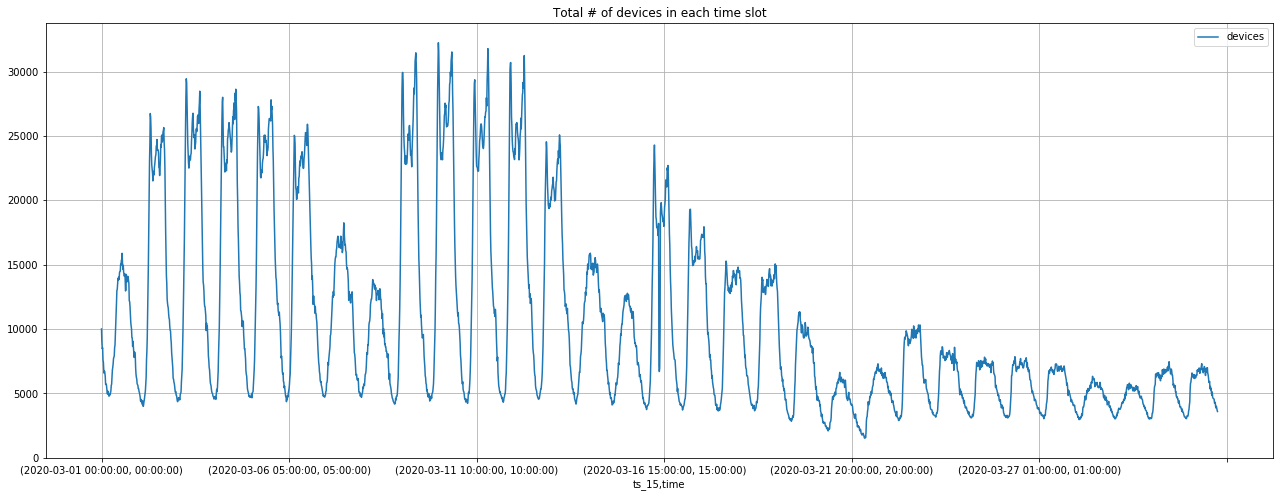

In [8]:
total_devices_time = total_devices_time[['devices', 'pings']]
total_devices_time['devices'].plot(figsize=(22, 8), legend=True, grid =True, title = 'Total # of devices in each time slot')

## Normalization

In [9]:
tile_frequency = march_london.tileid.value_counts().compute()

In [10]:
tile_frequency[:10]

C6FB7DD7D6    2943
C6FBB215B1    2924
C6FB7EAF08    2912
C6FBB31B5E    2902
C6FBB3A1CC    2877
C6FBB161AB    2872
C6FC8001AD    2871
C6FBB2A27D    2868
C6FBB35475    2853
C6FBB3A08C    2838
Name: tileid, dtype: int64

In [30]:
################ Not a dask dataframe ##################
march_C6FB7DD7D6 = march_london[march_london.tileid == 'C6FB7DD7D6'].compute()
march_C6FB7DD7D6.head()

,tileid,devices,new_devices,pings,avg_lat,avg_lon,time
ts_15,,,,,,,
2020-03-01 00:00:00,C6FB7DD7D6,1,1.0,2,51.491605,-0.158573,00:00:00
2020-03-01 00:15:00,C6FB7DD7D6,1,NaN,3,51.491609,-0.158571,00:15:00
2020-03-01 00:30:00,C6FB7DD7D6,1,NaN,3,51.491602,-0.158576,00:30:00
2020-03-01 00:45:00,C6FB7DD7D6,1,NaN,2,51.491611,-0.158567,00:45:00
2020-03-01 01:00:00,C6FB7DD7D6,1,NaN,2,51.491601,-0.158576,01:00:00


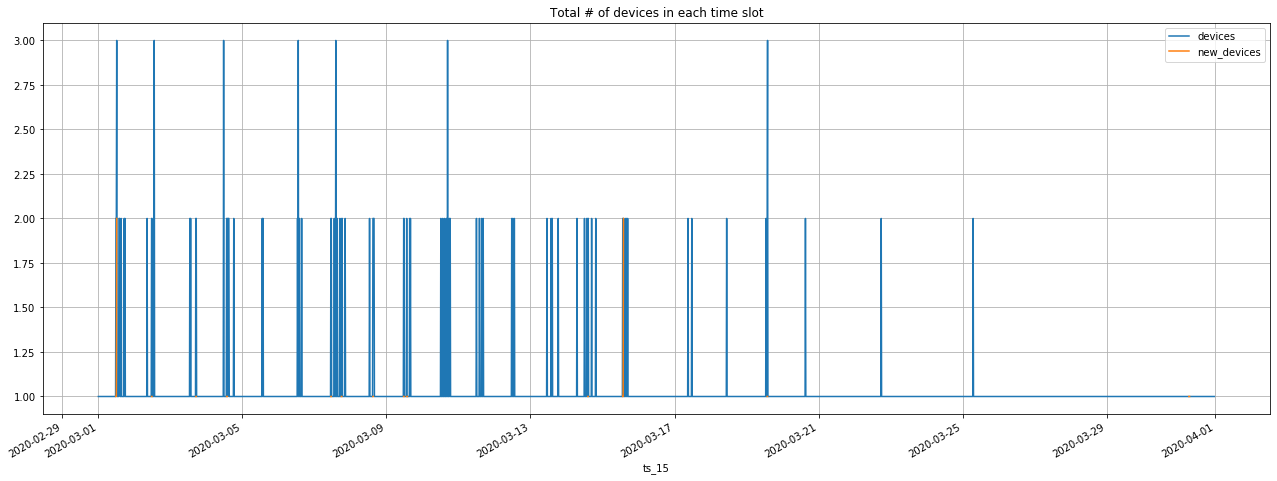

In [33]:
march_C6FB7DD7D6[['devices','new_devices']].plot(figsize=(22, 8), legend=True, grid =True, title = 'Total # of devices in each time slot')

In [45]:
import folium
from IPython.display import HTML, display
tileid = 'C6FB7DD7D6'
bbox = aux_functions.get_tile_bbox(tileid)
map1 = folium.Map(location= bbox[0], zoom_start=21)
folium.Rectangle([bbox[0] , bbox[2]], popup=tileid, fill = True, color='green', fill_opacity=0.2).add_to(map1)
#display(map1)

In [51]:
march_C6FB7DD7D6[['devices','new_devices']].groupby(march_C6FB7DD7D6.index.strftime("%Y-%m-%d")).sum()

,devices,new_devices
ts_15,,
2020-03-01,106,10.0
2020-03-02,101,5.0
2020-03-03,100,4.0
2020-03-04,105,7.0
2020-03-05,98,2.0
2020-03-06,100,6.0
2020-03-07,105,10.0
2020-03-08,101,3.0
2020-03-09,100,8.0


In [52]:
march_C6FB7DD7D6.head(100)

,tileid,devices,new_devices,pings,avg_lat,avg_lon,time
ts_15,,,,,,,
2020-03-01 00:00:00,C6FB7DD7D6,1,1.0,2,51.491605,-0.158573,00:00:00
2020-03-01 00:15:00,C6FB7DD7D6,1,NaN,3,51.491609,-0.158571,00:15:00
2020-03-01 00:30:00,C6FB7DD7D6,1,NaN,3,51.491602,-0.158576,00:30:00
2020-03-01 00:45:00,C6FB7DD7D6,1,NaN,2,51.491611,-0.158567,00:45:00
2020-03-01 01:00:00,C6FB7DD7D6,1,NaN,2,51.491601,-0.158576,01:00:00
...,...,...,...,...,...,...,...
2020-03-01 23:45:00,C6FB7DD7D6,1,NaN,2,51.491602,-0.158576,23:45:00
2020-03-02 00:00:00,C6FB7DD7D6,1,NaN,2,51.491603,-0.158576,00:00:00
2020-03-02 00:15:00,C6FB7DD7D6,1,NaN,3,51.491601,-0.158577,00:15:00


# Distribution calculation 

In [53]:
tile_max_devices_count = march_london[['tileid' , 'devices', 'pings']].groupby('tileid').max().compute()
#tile_max_devices_count.sort_values('devices', ascending = False, inplace = True).compute()

In [54]:
tile_max_devices_count.sort_values(by = 'devices', ascending = False, inplace=True)
tile_max_devices_count['tileid'] = tile_max_devices_count.index
tile_max_devices_count

,devices,pings,tileid
tileid,,,
C6FBB228FE,67,116,C6FBB228FE
C6FBB262B7,61,94,C6FBB262B7
C6FBB26278,44,57,C6FBB26278
C6FBB203C2,44,51,C6FBB203C2
C6FBB26385,42,60,C6FBB26385
...,...,...,...
C6FC809002,1,1,C6FC809002
C6FC8087B0,1,2,C6FC8087B0
C6FC808777,1,10,C6FC808777


In [55]:
frequent_tiles = tile_max_devices_count[tile_max_devices_count['devices'] > 4]['tileid'].to_list()
len(frequent_tiles)

8774

In [131]:
march_london_sample = march_london[march_london.tileid.isin(frequent_tiles)]
march_london_sample.shape, len(march_london_sample.tileid.unique())

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.01 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.03 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 2.87 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.06 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.25 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.99 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - gc.collect() took 5.562s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.worker - WARNING - gc.collect() took 14.375s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.07 GB -- Worker memory limit: 4.26 GB
d

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.21 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.25 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.23 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.25 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.34 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.26 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.26 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.26 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.26 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - gc.collect() took 2.984s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.91 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - gc.collect() took 1.516s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.91 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
di

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.65 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.68 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - gc.collect() took 1.891s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.70 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distrib

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.63 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.63 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.63 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.63 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.02 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.02 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.96 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.87 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.90 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.90 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.90 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.58 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.58 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.58 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.58 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.58 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.03 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.03 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.08 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.02 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.02 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.32 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.34 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.37 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.38 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.14 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.14 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.14 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.09 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 6.13 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.45 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.46 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.46 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.46 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.38 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.29 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.31 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.31 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.33 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.34 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.44 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.44 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.44 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.48 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.48 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.27 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.27 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.27 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.27 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.27 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.05 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.05 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.01 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.02 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.95 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.95 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.96 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.97 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.97 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.92 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.97 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 5.09 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.worker - WARNING - gc.collect() took 1.312s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other 

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.86 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.74 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.77 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.85 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.95 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.97 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.19 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.19 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.24 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.24 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.24 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

((Delayed('int-207925ab-2d24-4eb0-80dd-e12d591cda00'), 6), 8774)

In [132]:
march_london_sample.head()

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.worker - WARNING - gc.collect() took 2.375s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Worker is at 91% memory usage. Pausing worker.  Process memory: 3.91 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 4.60 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.59 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Worker is at 108% memory usage. Pausing worker.  Process memory: 4.63 GB -- Worker memory limit:

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.21 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.21 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.worker - WARNING - gc.collect() took 1.562s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.50 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other 

distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.42 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.42 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.42 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.43 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.43 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to 

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.56 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.57 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.59 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.60 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.61 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.61 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.63 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.64 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.65 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.65 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.53 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.59 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.52 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.56 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.50 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - gc.collect() took 1.891s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.53 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.51 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.51 GB -- Worker memory limit: 4.26 GB
distributed.worker -

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.57 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - gc.collect() took 2.781s. This is usually a sign that the some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.57 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.57 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distrib

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.25 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.27 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.19 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.19 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.21 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.16 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.20 GB -- Worker memory limit: 4.26 GB
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.15 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.09 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other proce

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.03 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 2.98 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.00 GB -- Worker memory limit: 4.26 GB
distributed.worker - WARN

,tileid,devices,pings,avg_lat,avg_lon,time
ts_15,,,,,,
2020-03-01,C6FBB26525,2,2,51.519941,-0.087530,00:00:00
2020-03-01,C6FBB24427,2,2,51.519978,-0.122244,00:00:00
2020-03-01,C6FC4CD09B,1,1,51.487015,0.017571,00:00:00
2020-03-01,C6FC4CCC57,2,5,51.497475,0.001862,00:00:00
2020-03-01,C6FBB24DC8,1,1,51.530938,-0.121033,00:00:00


In [139]:
#march_london_sample.to_parquet('march_london_sample/2000-01.parquet', engine='pyarrow')
march_london_sample.shape[0].compute()

5498671

## Pattern of devices for sample data

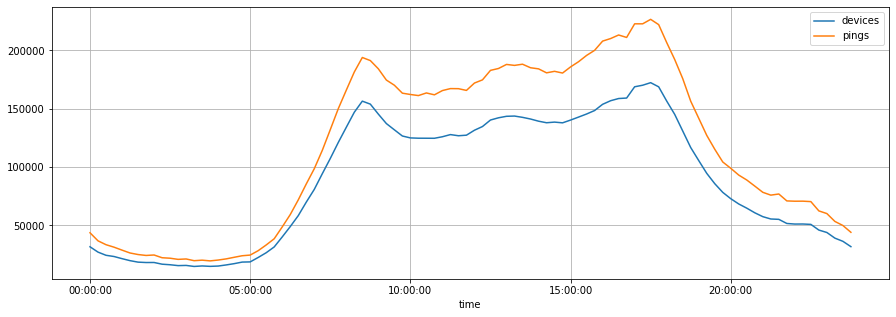

In [140]:
tile_max_devices_time_sample = march_london_sample.groupby('time')['time', 'devices' , 'pings'].sum().compute()
tile_max_devices_time_sample.plot(figsize=(15, 5), legend=True, grid =True)

## Adding Tile category for sampled data

In [212]:
london_index_tile_level_6 = pd.read_csv('london_index_tile_level_6.csv')

print(len(set(london_index_tile_level_6.tileid.to_list()) & set(frequent_tiles)))

6307


In [199]:
import aux_functions
london_index_level_6 = pd.read_csv('london_index_level_6.csv')
london_index_level_6['centroid_lat'] = london_index_level_6.apply(lambda x: aux_functions.get_tile_centroid( x['tileid'])[0], axis=1)
london_index_level_6['centroid_long'] = london_index_level_6.apply(lambda x: aux_functions.get_tile_centroid( x['tileid'])[1], axis=1)
london_index_level_6 = london_index_level_6[~london_index_level_6.tileid.isin(london_index_tile_level_6.tileid.to_list())]
london_index_level_6.shape

(102821, 7)

In [213]:
london_index_level_6 = london_index_level_6[london_index_level_6.tileid.isin(frequent_tiles)]
london_index_level_6.shape, london_index_level_6.head()

((2499, 11),
            tileid    min_lat  min_long    max_lat  max_long  centroid_lat  \
 16867  C6FBB242A8  51.518066 -0.115234  51.518311 -0.114990     51.518188   
 16869  C6FBB20C51  51.512695 -0.123779  51.512939 -0.123535     51.512817   
 16873  C6FB7DE210  51.484375 -0.147461  51.484619 -0.147217     51.484497   
 16874  C6FBB260B2  51.517578 -0.090332  51.517822 -0.090088     51.517700   
 16886  C6FBB13E2E  51.512451 -0.130371  51.512695 -0.130127     51.512573   
 
        centroid_long Category Type  Confidence Address  
 16867      -0.115112      NaN  NaN         NaN     NaN  
 16869      -0.123657      NaN  NaN         NaN     NaN  
 16873      -0.147339      NaN  NaN         NaN     NaN  
 16874      -0.090210      NaN  NaN         NaN     NaN  
 16886      -0.130249      NaN  NaN         NaN     NaN  )

In [211]:
#tile_details = []
#london_index_level_6 = london_index_level_6[:2499]
#london_index_level_6['tile_details_json'] = london_index_level_6.apply(lambda x: tile_catgeory( x['tileid'], tile_details), axis=1)

In [208]:
tile_details = pd.DataFrame(tile_details, columns = ['Category', 'Type', 'Confidence' , 'Address'])

london_index_level_6 = pd.concat([london_index_level_6, tile_details], axis = 1)
london_index_level_6.head()

,tileid,min_lat,min_long,max_lat,max_long,centroid_lat,centroid_long,Category,Type,Confidence,Address
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,building,building,10.0,"High Holborn House, Brownlow Street, London WC..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,commerce,restaurant,9.0,"Busaba Eathai, 44 Floral Street, London WC2E 9..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,road,road,9.0,"Grosvenor Bridge, Arches Lane, London SW11 8AB..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,building,building,10.0,"1 London Wall Place, London Wall, London EC2Y ..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,building,building,10.0,"One Thirty W1, Gerrard Place, London W1D 5PA, ..."


In [214]:
tile_cat = list(set(london_index_tile_level_6.tileid.to_list()) & set(frequent_tiles))
len(tile_cat)

6307

In [215]:
march_london_sample_tile_cat = march_london_sample[march_london_sample.tileid.isin(tile_cat)]
march_london_sample_tile_cat.shape, len(march_london_sample_tile_cat.tileid.unique())

((Delayed('int-04b946d3-e5d8-4fe2-8ce7-1fcf6f9a1e58'), 6), 6307)

In [216]:
march_london_sample_tile_cat = march_london_sample_tile_cat.merge(london_index_tile_level_6[['tileid' , 'Category', 'Type']] ,  how = 'left', on = 'tileid')
march_london_sample_tile_cat.shape[0].compute(), march_london_sample_tile_cat.columns

(4300258,
 Index(['tileid', 'devices', 'pings', 'avg_lat', 'avg_lon', 'time', 'Category',
        'Type'],
       dtype='object'))

In [217]:
march_london_sample_tile_cat.head()

,tileid,devices,pings,avg_lat,avg_lon,time,Category,Type
0,C6FBB26525,2,2,51.519941,-0.087530,00:00:00,road,road
1,C6FC4CD09B,1,1,51.487015,0.017571,00:00:00,road,road
2,C6FC4CCC57,2,5,51.497475,0.001862,00:00:00,road,road
3,C6FBB24DC8,1,1,51.530938,-0.121033,00:00:00,commerce,pub
4,C6FBB3094D,1,1,51.509678,-0.058140,00:00:00,outdoors/recreation,swimming_pool


In [218]:
march_london_sample_tile_cat.Category.value_counts().compute()

building               1746061
road                    864642
commerce                630504
transportation          392944
travel/tourism          272519
place                    98883
health                   85063
outdoors/recreation      82502
financial                41754
education                40619
government               16793
place_of_worship         16315
natural/water             5321
construction              2988
social                    2390
unknown                    960
Name: Category, dtype: int64

In [219]:
unique_category = march_london_sample_tile_cat.Category.unique().compute().to_list()
len(unique_category), unique_category[:3]

(16, ['road', 'commerce', 'outdoors/recreation'])

In [189]:
def devices_pattern(category):
    df = march_london_sample_tile_cat[march_london_sample_tile_cat.Category == category]
    df_pattern = df.groupby('time')['time', 'devices' , 'pings'].sum().compute()
    df_pattern.plot(figsize=(15, 5), legend=True, grid =True, title = category)

In [195]:
df = march_london_sample_tile_cat[march_london_sample_tile_cat.Category == category]
df_pattern = df.groupby('time')['time', 'devices' , 'pings'].sum().compute()
df_pattern

,devices,pings
time,,
00:00:00,4044,5242
00:15:00,3311,4277
00:30:00,3011,3925
00:45:00,2924,3770
01:00:00,2790,3626
...,...,...
22:45:00,5331,6839
23:00:00,5129,6498
23:15:00,4705,5901


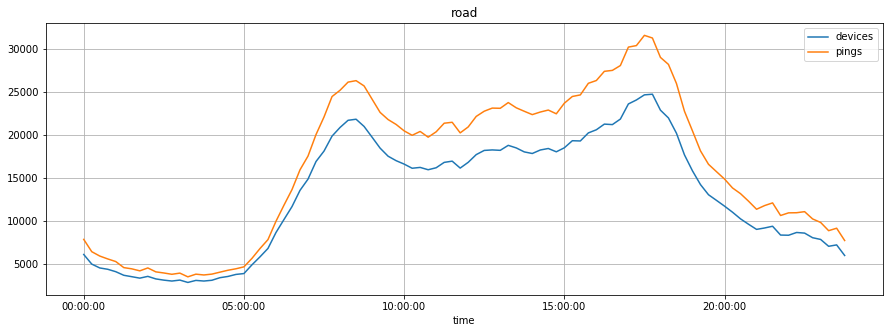

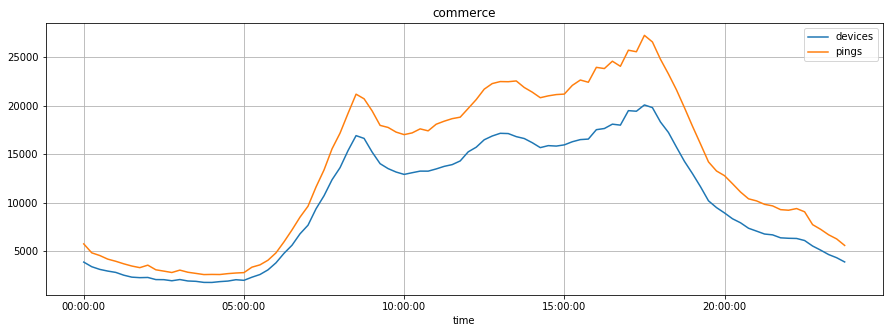

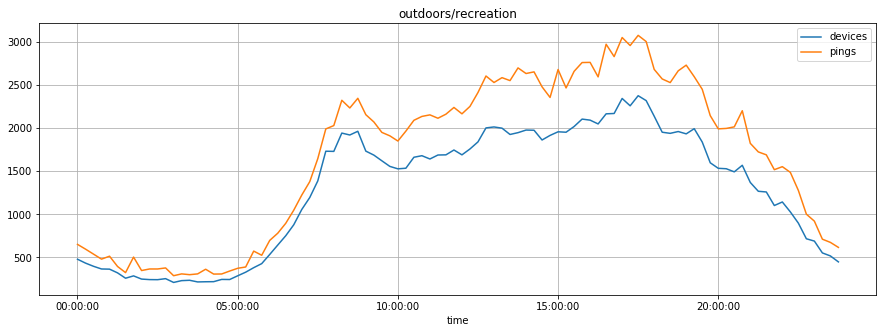

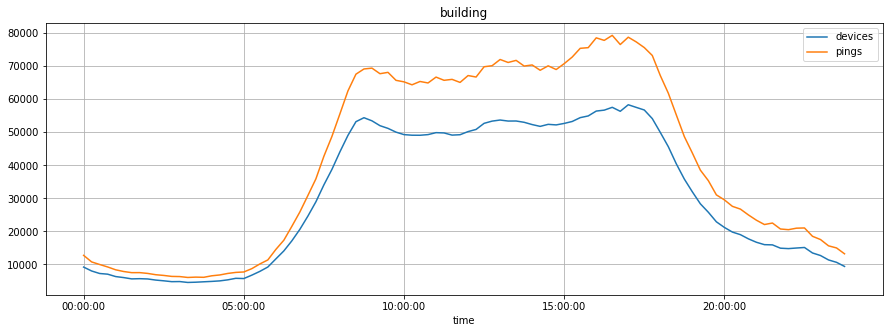

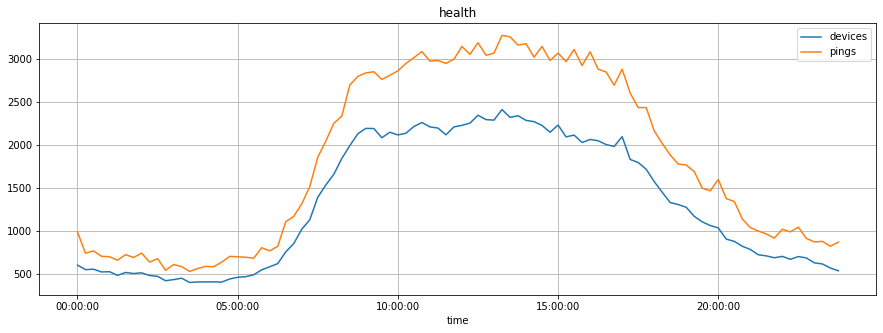

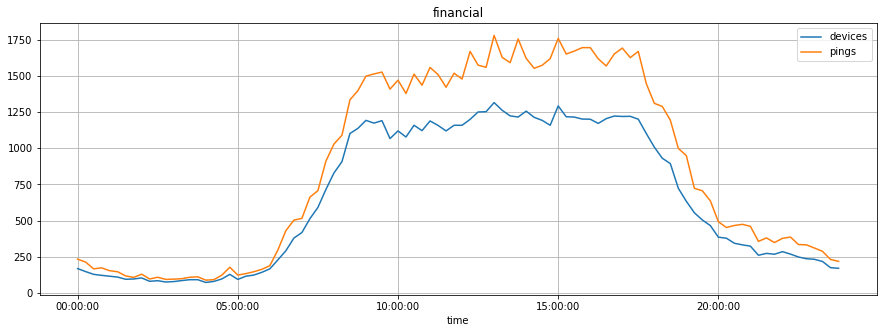

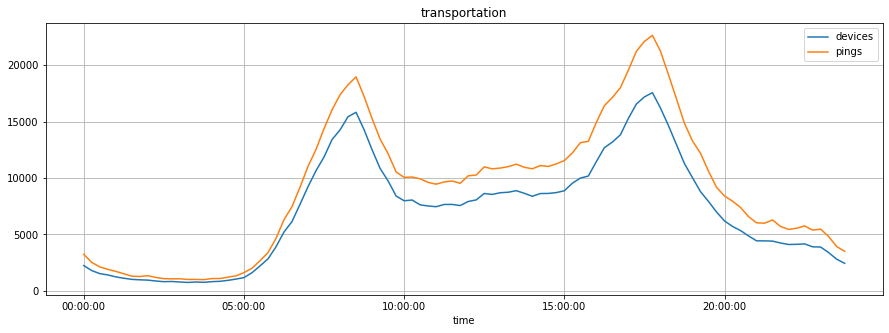

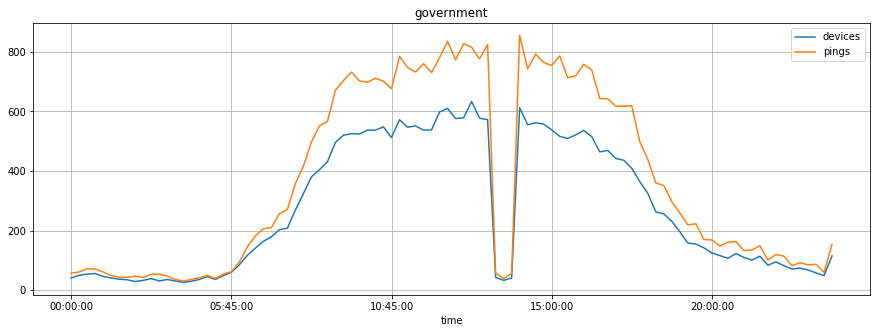

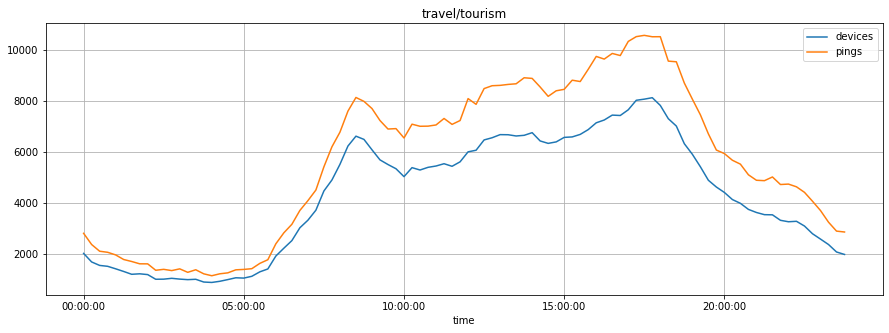

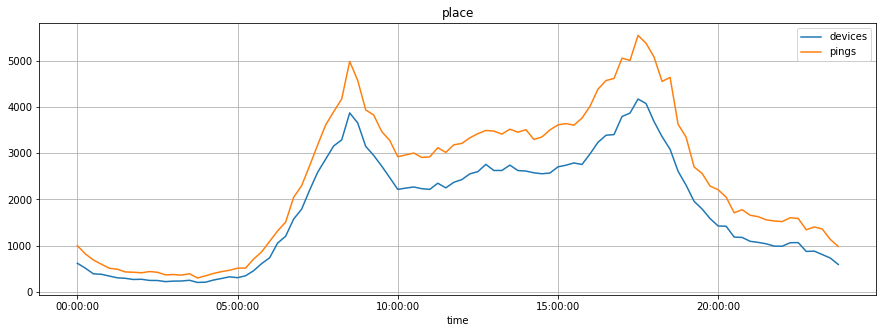

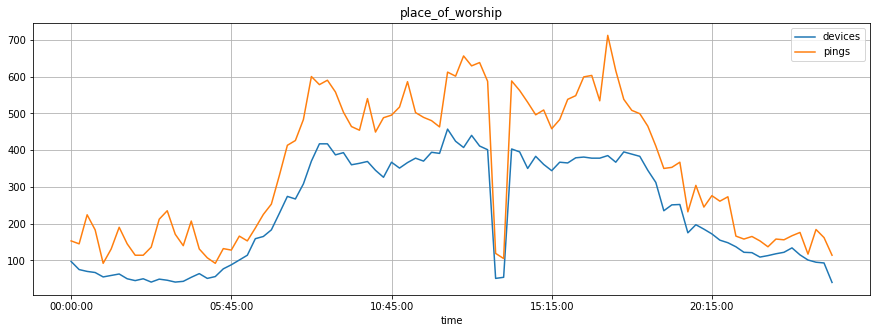

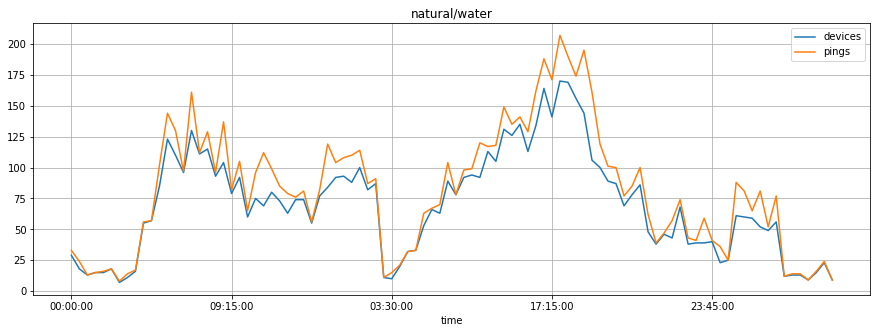

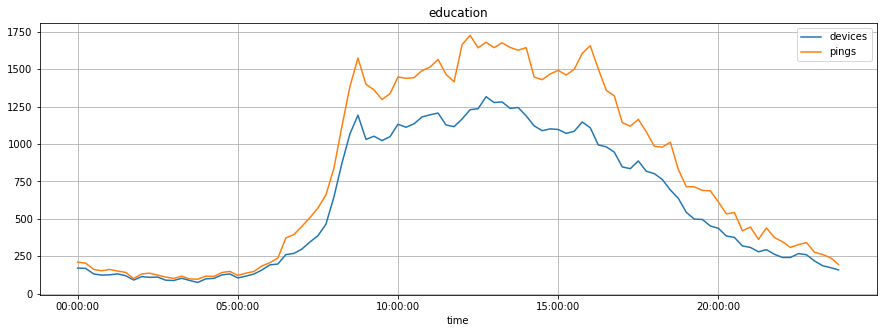

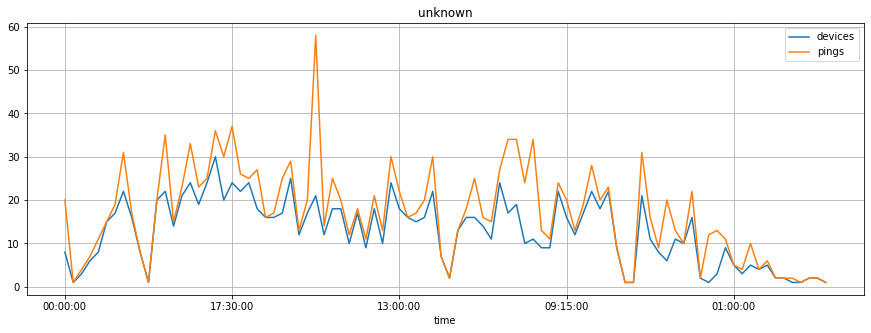

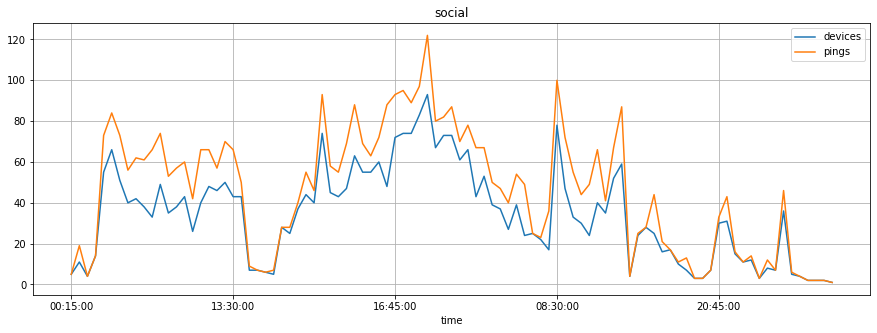

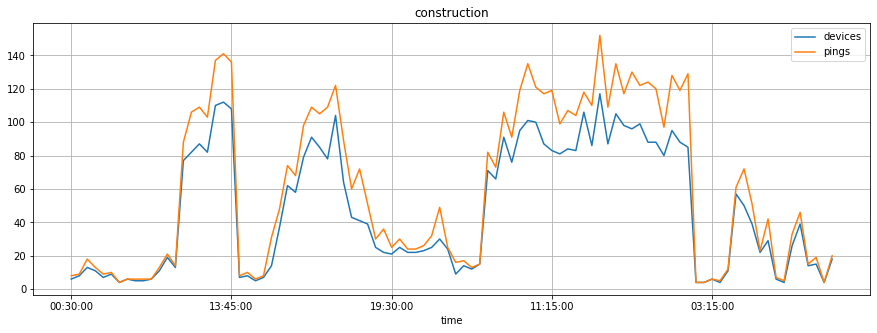

In [220]:
for category in unique_category:
    #devices_pattern(category)
    df = march_london_sample_tile_cat[march_london_sample_tile_cat.Category == category]
    df_pattern = df.groupby('time')['time', 'devices' , 'pings'].sum().compute()
    df_pattern.plot(figsize=(15, 5), legend=True, grid =True, title = category) 

## Pattern of devices on month data 

In [8]:
tile_max_devices_timewise = march_london.groupby('time')['time', 'devices' , 'pings'].sum().compute()
tile_max_devices_timewise.sort_values('devices', ascending = False)[:10]
tile_max_devices_timewise.plot(figsize=(15, 5), legend=True, grid =True)

,devices,pings
time,,
17:30:00,508482,694564
17:15:00,501296,679781
17:00:00,500811,685728
17:45:00,497344,676159
16:30:00,488694,675480
16:15:00,485545,666690
16:00:00,483654,671675
16:45:00,483110,662692
08:30:00,481155,636720


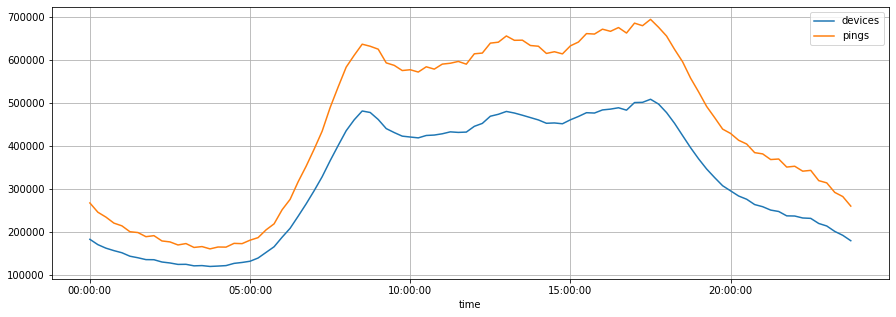

In [19]:
tile_max_devices_timewise.plot(figsize=(15, 5), legend=True, grid =True)

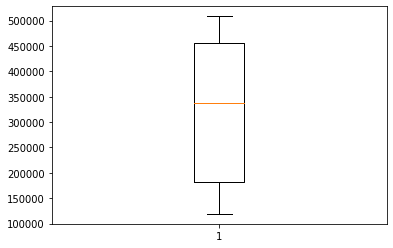

In [102]:
_ = plt.boxplot(tile_max_devices_timewise.devices)
#plt.hist(tile_max_devices_timewise.devices)

In [106]:
np.quantile(tile_max_devices_timewise.devices, [0.25, 0.5, 0.75, 1.0])

array([181547.  , 337101.5 , 455084.75, 508482.  ])

### Not completed - Distance calculation 

In [141]:
def distance_distribution(tileid, date, start_time, end_time):
    df = march_london_sample.loc[date]
    df = march_london_sample[march_london_sample.tileid == tileid]
    df = df.between_time(start_time, end_time)
    distances = []
    center_tile_loc = df.loc[:, ['avg_lat', 'avg_lon']].mean()
    print(df.shape)
    for key, lat_lon in tqdm(df.iterrows()):
        distances.append(geodesic(center_tile_loc.tolist(), lat_lon[['avg_lat', 'avg_lon']].tolist()).meters)
    mean,median,var = np.mean(distances), np.median(distances), np.var(distances)
    return(mean, median, var, df.shape[0])

In [144]:
distance_distribution_result = []
time_slots = [['23:00:01', '05:00:00'] ,['05:00:01', '11:00:00'], ['11:00:01', '17:00:00'], ['17:00:01', '23:00:00']]
unique_date = march_london_sample.index.strftime("%Y-%m-%d").unique().to_list()
for tileid in march_london_sample.tileid.unique():
    print(tileid)
    for date in unique_date:
        for [start_time, end_time] in time_slots:
            mean, median, var, sample_size = distance_distribution(tileid, date, start_time, end_time)
            distance_distribution_result.append([tileid, date, start_time, end_time, mean, median, var, sample_size])

C6FBB211FC
2020-03-01
(6, 6)


6it [00:00, 462.79it/s]


(3, 6)


3it [00:00, 429.79it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 334.24it/s]


2020-03-02
(6, 6)


6it [00:00, 546.88it/s]


(3, 6)


3it [00:00, 376.02it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 364.60it/s]


2020-03-03
(6, 6)


6it [00:00, 353.90it/s]


(3, 6)


3it [00:00, 300.82it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 364.71it/s]


2020-03-04
(6, 6)


6it [00:00, 334.22it/s]


(3, 6)


3it [00:00, 334.28it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 143.24it/s]


2020-03-05
(6, 6)


6it [00:00, 334.23it/s]


(3, 6)


3it [00:00, 334.20it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 364.56it/s]


2020-03-06
(6, 6)


6it [00:00, 261.53it/s]


(3, 6)


3it [00:00, 371.53it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 331.47it/s]


2020-03-07
(6, 6)


6it [00:00, 298.18it/s]


(3, 6)


3it [00:00, 248.40it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, ?it/s]


2020-03-08
(6, 6)


6it [00:00, 596.32it/s]


(3, 6)


3it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 220.87it/s]


2020-03-09
(6, 6)


6it [00:00, 384.10it/s]


(3, 6)


3it [00:00, 302.98it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 221.04it/s]


2020-03-10
(6, 6)


6it [00:00, 214.28it/s]


(3, 6)


3it [00:00, 442.94it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 113.42it/s]


2020-03-11
(6, 6)


6it [00:00, 591.69it/s]


(3, 6)


3it [00:00, 343.78it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 293.31it/s]


2020-03-12
(6, 6)


6it [00:00, 600.66it/s]


(3, 6)


3it [00:00, 540.87it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 499.87it/s]


2020-03-13
(6, 6)


6it [00:00, 443.57it/s]


(3, 6)


3it [00:00, 212.83it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 389.61it/s]


2020-03-14
(6, 6)


6it [00:00, 619.24it/s]


(3, 6)


3it [00:00, 340.36it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 279.52it/s]


2020-03-15
(6, 6)


6it [00:00, 462.78it/s]


(3, 6)


3it [00:00, 283.35it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 389.58it/s]


2020-03-16
(6, 6)


6it [00:00, 512.31it/s]


(3, 6)


3it [00:00, 355.07it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 244.66it/s]


2020-03-17
(6, 6)


6it [00:00, 713.32it/s]


(3, 6)


3it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 222.64it/s]


2020-03-18
(6, 6)


6it [00:00, 355.44it/s]


(3, 6)


3it [00:00, 429.74it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 275.96it/s]


2020-03-19
(6, 6)


6it [00:00, 406.06it/s]


(3, 6)


3it [00:00, 340.81it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 459.89it/s]


2020-03-20
(6, 6)


6it [00:00, 386.62it/s]


(3, 6)


3it [00:00, 250.55it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 186.11it/s]


2020-03-21
(6, 6)


6it [00:00, 562.24it/s]


(3, 6)


3it [00:00, 507.15it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 869.96it/s]


2020-03-22
(6, 6)


6it [00:00, 544.14it/s]


(3, 6)


3it [00:00, 277.60it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 630.18it/s]


2020-03-23
(6, 6)


6it [00:00, 747.43it/s]


(3, 6)


3it [00:00, 250.21it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 306.20it/s]


2020-03-24
(6, 6)


6it [00:00, 599.30it/s]


(3, 6)


3it [00:00, 530.92it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 338.20it/s]


2020-03-25
(6, 6)


6it [00:00, 347.08it/s]


(3, 6)


3it [00:00, 462.64it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 256.50it/s]


2020-03-26
(6, 6)


6it [00:00, 567.41it/s]


(3, 6)


3it [00:00, 401.61it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 435.34it/s]


2020-03-27
(6, 6)


6it [00:00, 609.18it/s]


(3, 6)


3it [00:00, 375.05it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 694.80it/s]


2020-03-28
(6, 6)


6it [00:00, 581.43it/s]


(3, 6)


3it [00:00, 215.85it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 337.94it/s]


2020-03-29
(6, 6)


6it [00:00, 748.09it/s]


(3, 6)


3it [00:00, 347.58it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 279.31it/s]


2020-03-30
(6, 6)


6it [00:00, 717.71it/s]


(3, 6)


3it [00:00, 299.12it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 476.96it/s]


2020-03-31
(6, 6)


6it [00:00, 430.02it/s]


(3, 6)


3it [00:00, 360.91it/s]


(0, 6)


0it [00:00, ?it/s]


(4, 6)


4it [00:00, 324.15it/s]


C6FBB12A64
2020-03-01
(1, 6)


1it [00:00, 249.94it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 125.09it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 244.84it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 491.25it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 1044.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 249.96it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 333.94it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 250.14it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, 249.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, 977.24it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, 33288.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 121.91it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 330.03it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 492.87it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, 548.71it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, 396.14it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, 570.65it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 656.49it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 477.98it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 127.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 121.82it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 250.12it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, 250.03it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB2635D
2020-03-01
(4, 6)


4it [00:00, 400.69it/s]


(60, 6)


60it [00:00, 494.80it/s]


(66, 6)


66it [00:00, 521.79it/s]


(82, 6)


82it [00:00, 457.37it/s]


2020-03-02
(4, 6)


4it [00:00, 569.65it/s]


(60, 6)


60it [00:00, 628.47it/s]


(66, 6)


66it [00:00, 481.39it/s]


(82, 6)


82it [00:00, 613.61it/s]


2020-03-03
(4, 6)


4it [00:00, 572.23it/s]


(60, 6)


60it [00:00, 593.35it/s]


(66, 6)


66it [00:00, 556.69it/s]


(82, 6)


82it [00:00, 535.67it/s]


2020-03-04
(4, 6)


4it [00:00, 500.47it/s]


(60, 6)


60it [00:00, 496.79it/s]


(66, 6)


66it [00:00, 560.05it/s]


(82, 6)


82it [00:00, 615.86it/s]


2020-03-05
(4, 6)


4it [00:00, 506.82it/s]


(60, 6)


60it [00:00, 505.37it/s]


(66, 6)


66it [00:00, 496.98it/s]


(82, 6)


82it [00:00, 632.89it/s]


2020-03-06
(4, 6)


4it [00:00, 516.46it/s]


(60, 6)


60it [00:00, 504.44it/s]


(66, 6)


66it [00:00, 591.07it/s]


(82, 6)


82it [00:00, 572.66it/s]


2020-03-07
(4, 6)


4it [00:00, 201.99it/s]


(60, 6)


60it [00:00, 497.64it/s]


(66, 6)


66it [00:00, 515.26it/s]


(82, 6)


82it [00:00, 609.23it/s]


2020-03-08
(4, 6)


4it [00:00, 387.63it/s]


(60, 6)


60it [00:00, 476.76it/s]


(66, 6)


66it [00:00, 455.79it/s]


(82, 6)


82it [00:00, 435.87it/s]


2020-03-09
(4, 6)


4it [00:00, 344.05it/s]


(60, 6)


60it [00:00, 511.43it/s]


(66, 6)


66it [00:00, 580.13it/s]


(82, 6)


82it [00:00, 577.75it/s]


2020-03-10
(4, 6)


4it [00:00, 530.40it/s]


(60, 6)


60it [00:00, 609.32it/s]


(66, 6)


66it [00:00, 598.41it/s]


(82, 6)


82it [00:00, 687.60it/s]


2020-03-11
(4, 6)


4it [00:00, 499.99it/s]


(60, 6)


60it [00:00, 538.32it/s]


(66, 6)


66it [00:00, 608.63it/s]


(82, 6)


82it [00:00, 696.50it/s]


2020-03-12
(4, 6)


4it [00:00, 391.37it/s]


(60, 6)


60it [00:00, 659.32it/s]


(66, 6)


66it [00:00, 584.32it/s]


(82, 6)


82it [00:00, 515.81it/s]


2020-03-13
(4, 6)


4it [00:00, 402.06it/s]


(60, 6)


60it [00:00, 518.98it/s]


(66, 6)


66it [00:00, 536.00it/s]


(82, 6)


82it [00:00, 520.65it/s]


2020-03-14
(4, 6)


4it [00:00, 522.41it/s]


(60, 6)


60it [00:00, 648.16it/s]


(66, 6)


66it [00:00, 474.81it/s]


(82, 6)


82it [00:00, 559.86it/s]


2020-03-15
(4, 6)


4it [00:00, 541.92it/s]


(60, 6)


60it [00:00, 465.30it/s]


(66, 6)


66it [00:00, 547.17it/s]


(82, 6)


82it [00:00, 632.17it/s]


2020-03-16
(4, 6)


4it [00:00, 398.34it/s]


(60, 6)


60it [00:00, 334.64it/s]


(66, 6)


66it [00:00, 410.49it/s]


(82, 6)


82it [00:00, 439.12it/s]


2020-03-17
(4, 6)


4it [00:00, 302.36it/s]


(60, 6)


60it [00:00, 555.81it/s]


(66, 6)


66it [00:00, 575.46it/s]


(82, 6)


82it [00:00, 610.58it/s]


2020-03-18
(4, 6)


4it [00:00, 262.14it/s]


(60, 6)


60it [00:00, 593.31it/s]


(66, 6)


66it [00:00, 437.50it/s]


(82, 6)


82it [00:00, 569.01it/s]


2020-03-19
(4, 6)


4it [00:00, 536.30it/s]


(60, 6)


60it [00:00, 354.71it/s]


(66, 6)


66it [00:00, 557.98it/s]


(82, 6)


82it [00:00, 538.66it/s]


2020-03-20
(4, 6)


4it [00:00, 497.01it/s]


(60, 6)


60it [00:00, 504.53it/s]


(66, 6)


66it [00:00, 500.39it/s]


(82, 6)


82it [00:00, 535.52it/s]


2020-03-21
(4, 6)


4it [00:00, 580.97it/s]


(60, 6)


60it [00:00, 468.83it/s]


(66, 6)


66it [00:00, 592.75it/s]


(82, 6)


82it [00:00, 637.58it/s]


2020-03-22
(4, 6)


4it [00:00, 315.53it/s]


(60, 6)


60it [00:00, 522.64it/s]


(66, 6)


66it [00:00, 549.42it/s]


(82, 6)


82it [00:00, 598.94it/s]


2020-03-23
(4, 6)


4it [00:00, 546.99it/s]


(60, 6)


60it [00:00, 594.11it/s]


(66, 6)


66it [00:00, 539.11it/s]


(82, 6)


82it [00:00, 647.26it/s]


2020-03-24
(4, 6)


4it [00:00, 263.62it/s]


(60, 6)


60it [00:00, 458.41it/s]


(66, 6)


66it [00:00, 596.14it/s]


(82, 6)


82it [00:00, 270.97it/s]


2020-03-25
(4, 6)


4it [00:00, 471.23it/s]


(60, 6)


60it [00:00, 521.77it/s]


(66, 6)


66it [00:00, 516.16it/s]


(82, 6)


82it [00:00, 534.86it/s]


2020-03-26
(4, 6)


4it [00:00, 257.73it/s]


(60, 6)


60it [00:00, 521.42it/s]


(66, 6)


66it [00:00, 503.58it/s]


(82, 6)


82it [00:00, 582.56it/s]


2020-03-27
(4, 6)


4it [00:00, 397.47it/s]


(60, 6)


60it [00:00, 492.25it/s]


(66, 6)


66it [00:00, 523.60it/s]


(82, 6)


82it [00:00, 497.87it/s]


2020-03-28
(4, 6)


4it [00:00, 445.56it/s]


(60, 6)


60it [00:00, 501.04it/s]


(66, 6)


66it [00:00, 511.40it/s]


(82, 6)


82it [00:00, 643.06it/s]


2020-03-29
(4, 6)


4it [00:00, 435.78it/s]


(60, 6)


60it [00:00, 640.00it/s]


(66, 6)


66it [00:00, 525.45it/s]


(82, 6)


82it [00:00, 451.17it/s]


2020-03-30
(4, 6)


4it [00:00, 490.75it/s]


(60, 6)


60it [00:00, 540.22it/s]


(66, 6)


66it [00:00, 566.97it/s]


(82, 6)


82it [00:00, 542.06it/s]


2020-03-31
(4, 6)


4it [00:00, 305.09it/s]


(60, 6)


60it [00:00, 508.56it/s]


(66, 6)


66it [00:00, 483.73it/s]


(82, 6)


82it [00:00, 607.89it/s]


C6FBB17F52
2020-03-01
(2, 6)


2it [00:00, 241.39it/s]


(6, 6)


6it [00:00, 485.55it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(2, 6)


2it [00:00, 302.73it/s]


(6, 6)


6it [00:00, 329.41it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(2, 6)


2it [00:00, 1305.42it/s]


(6, 6)


6it [00:00, 331.08it/s]


(1, 6)


1it [00:00, 249.96it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(2, 6)


2it [00:00, 1209.26it/s]


(6, 6)


6it [00:00, 348.69it/s]


(1, 6)


1it [00:00, 290.42it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(2, 6)


2it [00:00, 251.74it/s]


(6, 6)


6it [00:00, 294.48it/s]


(1, 6)


1it [00:00, 240.46it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(2, 6)


2it [00:00, 296.71it/s]


(6, 6)


6it [00:00, 377.37it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(2, 6)


2it [00:00, 250.03it/s]


(6, 6)


6it [00:00, 579.87it/s]


(1, 6)


1it [00:00, 149.06it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(2, 6)


2it [00:00, 661.46it/s]


(6, 6)


6it [00:00, 410.37it/s]


(1, 6)


1it [00:00, 85.17it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(2, 6)


2it [00:00, 486.61it/s]


(6, 6)


6it [00:00, 421.22it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(2, 6)


2it [00:00, 420.17it/s]


(6, 6)


6it [00:00, 715.39it/s]


(1, 6)


1it [00:00, 206.76it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(2, 6)


2it [00:00, 327.67it/s]


(6, 6)


6it [00:00, 395.74it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(2, 6)


2it [00:00, 425.77it/s]


(6, 6)


6it [00:00, 169.04it/s]


(1, 6)


1it [00:00, 333.91it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(2, 6)


2it [00:00, 196.89it/s]


(6, 6)


6it [00:00, 263.80it/s]


(1, 6)


1it [00:00, 294.77it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(2, 6)


2it [00:00, 246.80it/s]


(6, 6)


6it [00:00, 390.87it/s]


(1, 6)


1it [00:00, 193.17it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(2, 6)


2it [00:00, 296.74it/s]


(6, 6)


6it [00:00, 474.70it/s]


(1, 6)


1it [00:00, 301.62it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(2, 6)


2it [00:00, 167.43it/s]


(6, 6)


6it [00:00, 435.04it/s]


(1, 6)


1it [00:00, 82.56it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(2, 6)


2it [00:00, ?it/s]


(6, 6)


6it [00:00, 376.06it/s]


(1, 6)


1it [00:00, 217.85it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(2, 6)


2it [00:00, 199.13it/s]


(6, 6)


6it [00:00, 369.29it/s]


(1, 6)


1it [00:00, 175.75it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(2, 6)


2it [00:00, 660.42it/s]


(6, 6)


6it [00:00, 136.37it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(2, 6)


2it [00:00, 1044.53it/s]


(6, 6)


6it [00:00, 370.15it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(2, 6)


2it [00:00, 244.70it/s]


(6, 6)


6it [00:00, 420.28it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(2, 6)


2it [00:00, 2431.48it/s]


(6, 6)


6it [00:00, 326.91it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(2, 6)


2it [00:00, 196.74it/s]


(6, 6)


6it [00:00, 462.82it/s]


(1, 6)


1it [00:00, 123.02it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(2, 6)


2it [00:00, 241.93it/s]


(6, 6)


6it [00:00, 429.72it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(2, 6)


2it [00:00, 241.04it/s]


(6, 6)


6it [00:00, 335.89it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(2, 6)


2it [00:00, 492.12it/s]


(6, 6)


6it [00:00, 566.17it/s]


(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(2, 6)


2it [00:00, 316.47it/s]


(6, 6)


6it [00:00, 334.53it/s]


(1, 6)


1it [00:00, 216.37it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(2, 6)


2it [00:00, 255.35it/s]


(6, 6)


6it [00:00, 472.43it/s]


(1, 6)


1it [00:00, 124.64it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(2, 6)


2it [00:00, 3018.57it/s]


(6, 6)


6it [00:00, 592.86it/s]


(1, 6)


1it [00:00, 96.79it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(2, 6)


2it [00:00, 970.01it/s]


(6, 6)


6it [00:00, 592.64it/s]


(1, 6)


1it [00:00, 266.59it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(2, 6)


2it [00:00, 249.94it/s]


(6, 6)


6it [00:00, 370.10it/s]


(1, 6)


1it [00:00, 116.72it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB22535
2020-03-01
(2, 6)


2it [00:00, 373.91it/s]


(16, 6)


16it [00:00, 613.28it/s]


(109, 6)


109it [00:00, 545.07it/s]


(81, 6)


81it [00:00, 539.87it/s]


2020-03-02
(2, 6)


2it [00:00, 106.62it/s]


(16, 6)


16it [00:00, 882.90it/s]


(109, 6)


109it [00:00, 536.79it/s]


(81, 6)


81it [00:00, 568.52it/s]


2020-03-03
(2, 6)


2it [00:00, 198.80it/s]


(16, 6)


16it [00:00, 454.06it/s]


(109, 6)


109it [00:00, 573.13it/s]


(81, 6)


81it [00:00, 552.96it/s]


2020-03-04
(2, 6)


2it [00:00, 892.60it/s]


(16, 6)


16it [00:00, 798.75it/s]


(109, 6)


109it [00:00, 524.26it/s]


(81, 6)


81it [00:00, 473.33it/s]


2020-03-05
(2, 6)


2it [00:00, 193.43it/s]


(16, 6)


16it [00:00, 681.81it/s]


(109, 6)


109it [00:00, 470.32it/s]


(81, 6)


81it [00:00, 650.64it/s]


2020-03-06
(2, 6)


2it [00:00, 323.09it/s]


(16, 6)


16it [00:00, 882.25it/s]


(109, 6)


109it [00:00, 542.22it/s]


(81, 6)


81it [00:00, 478.49it/s]


2020-03-07
(2, 6)


2it [00:00, 201.73it/s]


(16, 6)


16it [00:00, 592.78it/s]


(109, 6)


109it [00:00, 633.85it/s]


(81, 6)


81it [00:00, 444.24it/s]


2020-03-08
(2, 6)


2it [00:00, 251.57it/s]


(16, 6)


16it [00:00, 803.04it/s]


(109, 6)


109it [00:00, 600.05it/s]


(81, 6)


81it [00:00, 594.38it/s]


2020-03-09
(2, 6)


2it [00:00, 244.42it/s]


(16, 6)


16it [00:00, 374.80it/s]


(109, 6)


109it [00:00, 482.91it/s]


(81, 6)


81it [00:00, 512.54it/s]


2020-03-10
(2, 6)


2it [00:00, 499.89it/s]


(16, 6)


16it [00:00, 456.96it/s]


(109, 6)


109it [00:00, 592.10it/s]


(81, 6)


81it [00:00, 611.01it/s]


2020-03-11
(2, 6)


2it [00:00, 409.42it/s]


(16, 6)


16it [00:00, 501.45it/s]


(109, 6)


109it [00:00, 599.04it/s]


(81, 6)


81it [00:00, 339.42it/s]


2020-03-12
(2, 6)


2it [00:00, 501.59it/s]


(16, 6)


16it [00:00, 417.97it/s]


(109, 6)


109it [00:00, 544.77it/s]


(81, 6)


81it [00:00, 559.08it/s]


2020-03-13
(2, 6)


2it [00:00, 291.42it/s]


(16, 6)


16it [00:00, 666.52it/s]


(109, 6)


109it [00:00, 542.38it/s]


(81, 6)


81it [00:00, 488.43it/s]


2020-03-14
(2, 6)


2it [00:00, 561.56it/s]


(16, 6)


16it [00:00, 533.74it/s]


(109, 6)


109it [00:00, 569.85it/s]


(81, 6)


81it [00:00, 510.34it/s]


2020-03-15
(2, 6)


2it [00:00, 409.64it/s]


(16, 6)


16it [00:00, 341.75it/s]


(109, 6)


109it [00:00, 659.68it/s]


(81, 6)


81it [00:00, 604.33it/s]


2020-03-16
(2, 6)


2it [00:00, ?it/s]


(16, 6)


16it [00:00, 1001.61it/s]


(109, 6)


109it [00:00, 484.96it/s]


(81, 6)


81it [00:00, 628.89it/s]


2020-03-17
(2, 6)


2it [00:00, 253.16it/s]


(16, 6)


16it [00:00, 562.39it/s]


(109, 6)


109it [00:00, 588.39it/s]


(81, 6)


81it [00:00, 653.53it/s]


2020-03-18
(2, 6)


2it [00:00, 334.09it/s]


(16, 6)


16it [00:00, 797.61it/s]


(109, 6)


109it [00:00, 454.67it/s]


(81, 6)


81it [00:00, 442.37it/s]


2020-03-19
(2, 6)


2it [00:00, ?it/s]


(16, 6)


16it [00:00, 567.46it/s]


(109, 6)


109it [00:00, 445.71it/s]


(81, 6)


81it [00:00, 405.76it/s]


2020-03-20
(2, 6)


2it [00:00, 928.56it/s]


(16, 6)


16it [00:00, 492.29it/s]


(109, 6)


109it [00:00, 619.38it/s]


(81, 6)


81it [00:00, 489.13it/s]


2020-03-21
(2, 6)


2it [00:00, 250.01it/s]


(16, 6)


16it [00:00, 532.00it/s]


(109, 6)


109it [00:00, 622.05it/s]


(81, 6)


81it [00:00, 589.27it/s]


2020-03-22
(2, 6)


2it [00:00, 214.62it/s]


(16, 6)


16it [00:00, 887.85it/s]


(109, 6)


109it [00:00, 473.72it/s]


(81, 6)


81it [00:00, 468.69it/s]


2020-03-23
(2, 6)


2it [00:00, 126.77it/s]


(16, 6)


16it [00:00, 471.95it/s]


(109, 6)


109it [00:00, 578.94it/s]


(81, 6)


81it [00:00, 569.07it/s]


2020-03-24
(2, 6)


2it [00:00, 145.02it/s]


(16, 6)


16it [00:00, 464.98it/s]


(109, 6)


109it [00:00, 567.48it/s]


(81, 6)


81it [00:00, 572.84it/s]


2020-03-25
(2, 6)


2it [00:00, 152.80it/s]


(16, 6)


16it [00:00, 506.63it/s]


(109, 6)


109it [00:00, 345.50it/s]


(81, 6)


81it [00:00, 282.83it/s]


2020-03-26
(2, 6)


2it [00:00, 249.43it/s]


(16, 6)


16it [00:00, 300.63it/s]


(109, 6)


109it [00:00, 373.10it/s]


(81, 6)


81it [00:00, 243.99it/s]


2020-03-27
(2, 6)


2it [00:00, 250.20it/s]


(16, 6)


16it [00:00, 232.32it/s]


(109, 6)


109it [00:00, 338.74it/s]


(81, 6)


81it [00:00, 308.07it/s]


2020-03-28
(2, 6)


2it [00:00, 249.22it/s]


(16, 6)


16it [00:00, 331.20it/s]


(109, 6)


109it [00:00, 327.19it/s]


(81, 6)


81it [00:00, 447.04it/s]


2020-03-29
(2, 6)


2it [00:00, 220.63it/s]


(16, 6)


16it [00:00, 658.30it/s]


(109, 6)


109it [00:00, 478.42it/s]


(81, 6)


81it [00:00, 289.03it/s]


2020-03-30
(2, 6)


2it [00:00, 714.17it/s]


(16, 6)


16it [00:00, 392.83it/s]


(109, 6)


109it [00:00, 580.73it/s]


(81, 6)


81it [00:00, 669.30it/s]


2020-03-31
(2, 6)


2it [00:00, 198.82it/s]


(16, 6)


16it [00:00, 743.65it/s]


(109, 6)


109it [00:00, 615.53it/s]


(81, 6)


81it [00:00, 592.98it/s]


C6FBB13A8B
2020-03-01
(11, 6)


11it [00:00, 544.23it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 449.61it/s]


(17, 6)


17it [00:00, 413.72it/s]


2020-03-02
(11, 6)


11it [00:00, 565.08it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 315.65it/s]


(17, 6)


17it [00:00, 445.37it/s]


2020-03-03
(11, 6)


11it [00:00, 509.59it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 444.42it/s]


(17, 6)


17it [00:00, 423.71it/s]


2020-03-04
(11, 6)


11it [00:00, 546.96it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 448.58it/s]


(17, 6)


17it [00:00, 520.94it/s]


2020-03-05
(11, 6)


11it [00:00, 453.68it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 350.82it/s]


(17, 6)


17it [00:00, 675.09it/s]


2020-03-06
(11, 6)


11it [00:00, 545.54it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 415.19it/s]


(17, 6)


17it [00:00, 420.15it/s]


2020-03-07
(11, 6)


11it [00:00, 218.72it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 497.79it/s]


(17, 6)


17it [00:00, 403.67it/s]


2020-03-08
(11, 6)


11it [00:00, 555.66it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 467.20it/s]


(17, 6)


17it [00:00, 382.90it/s]


2020-03-09
(11, 6)


11it [00:00, 1000.03it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 303.21it/s]


(17, 6)


17it [00:00, 785.56it/s]


2020-03-10
(11, 6)


11it [00:00, 940.29it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 248.42it/s]


(17, 6)


17it [00:00, 492.20it/s]


2020-03-11
(11, 6)


11it [00:00, 310.59it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 444.97it/s]


(17, 6)


17it [00:00, 472.02it/s]


2020-03-12
(11, 6)


11it [00:00, 362.47it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 624.27it/s]


(17, 6)


17it [00:00, 452.15it/s]


2020-03-13
(11, 6)


11it [00:00, 390.78it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 758.60it/s]


(17, 6)


17it [00:00, 750.54it/s]


2020-03-14
(11, 6)


11it [00:00, 509.45it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 553.65it/s]


(17, 6)


17it [00:00, 554.93it/s]


2020-03-15
(11, 6)


11it [00:00, 536.96it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 488.52it/s]


(17, 6)


17it [00:00, 349.91it/s]


2020-03-16
(11, 6)


11it [00:00, 390.63it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 445.12it/s]


(17, 6)


17it [00:00, 659.89it/s]


2020-03-17
(11, 6)


11it [00:00, 439.30it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 745.23it/s]


(17, 6)


17it [00:00, 450.29it/s]


2020-03-18
(11, 6)


11it [00:00, 364.09it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 288.04it/s]


(17, 6)


17it [00:00, 211.06it/s]


2020-03-19
(11, 6)


11it [00:00, 547.32it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 576.06it/s]


(17, 6)


17it [00:00, 560.18it/s]


2020-03-20
(11, 6)


11it [00:00, 704.15it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 446.29it/s]


(17, 6)


17it [00:00, 561.49it/s]


2020-03-21
(11, 6)


11it [00:00, 390.65it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 496.86it/s]


(17, 6)


17it [00:00, 298.87it/s]


2020-03-22
(11, 6)


11it [00:00, 352.12it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 745.36it/s]


(17, 6)


17it [00:00, 421.56it/s]


2020-03-23
(11, 6)


11it [00:00, 362.67it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 576.06it/s]


(17, 6)


17it [00:00, 509.77it/s]


2020-03-24
(11, 6)


11it [00:00, 545.54it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 894.33it/s]


(17, 6)


17it [00:00, 604.36it/s]


2020-03-25
(11, 6)


11it [00:00, 545.97it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 446.96it/s]


(17, 6)


17it [00:00, 604.06it/s]


2020-03-26
(11, 6)


11it [00:00, 447.94it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 530.83it/s]


(17, 6)


17it [00:00, 604.29it/s]


2020-03-27
(11, 6)


11it [00:00, 495.13it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 743.26it/s]


(17, 6)


17it [00:00, 422.52it/s]


2020-03-28
(11, 6)


11it [00:00, 911.14it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 406.16it/s]


(17, 6)


17it [00:00, 580.81it/s]


2020-03-29
(11, 6)


11it [00:00, 545.94it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 447.43it/s]


(17, 6)


17it [00:00, 421.61it/s]


2020-03-30
(11, 6)


11it [00:00, 398.37it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 446.25it/s]


(17, 6)


17it [00:00, 337.47it/s]


2020-03-31
(11, 6)


11it [00:00, 496.53it/s]


(0, 6)


0it [00:00, ?it/s]


(9, 6)


9it [00:00, 444.89it/s]


(17, 6)


17it [00:00, 509.80it/s]


C6FB7FC0F9
2020-03-01
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 124.53it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 493.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 493.62it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 64.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 64.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 124.46it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 493.97it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 494.61it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 494.32it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 493.62it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 493.51it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, 124.52it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 124.32it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB220D3
2020-03-01
(2, 6)


2it [00:00, 198.97it/s]


(35, 6)


35it [00:00, 589.39it/s]


(33, 6)


33it [00:00, 406.77it/s]


(18, 6)


18it [00:00, 576.08it/s]


2020-03-02
(2, 6)


2it [00:00, 249.22it/s]


(35, 6)


35it [00:00, 579.71it/s]


(33, 6)


33it [00:00, 655.50it/s]


(18, 6)


18it [00:00, 636.04it/s]


2020-03-03
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 746.69it/s]


(33, 6)


33it [00:00, 545.64it/s]


(18, 6)


18it [00:00, 596.57it/s]


2020-03-04
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 391.06it/s]


(33, 6)


33it [00:00, 250.75it/s]


(18, 6)


18it [00:00, 446.78it/s]


2020-03-05
(2, 6)


2it [00:00, 988.76it/s]


(35, 6)


35it [00:00, 578.54it/s]


(33, 6)


33it [00:00, 817.21it/s]


(18, 6)


18it [00:00, 688.67it/s]


2020-03-06
(2, 6)


2it [00:00, 248.68it/s]


(35, 6)


35it [00:00, 686.45it/s]


(33, 6)


33it [00:00, 565.39it/s]


(18, 6)


18it [00:00, 576.01it/s]


2020-03-07
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 746.66it/s]


(33, 6)


33it [00:00, 572.05it/s]


(18, 6)


18it [00:00, 594.89it/s]


2020-03-08
(2, 6)


2it [00:00, 248.18it/s]


(35, 6)


35it [00:00, 781.79it/s]


(33, 6)


33it [00:00, 595.16it/s]


(18, 6)


18it [00:00, 576.11it/s]


2020-03-09
(2, 6)


2it [00:00, 198.40it/s]


(35, 6)


35it [00:00, 696.33it/s]


(33, 6)


33it [00:00, 656.36it/s]


(18, 6)


18it [00:00, 714.86it/s]


2020-03-10
(2, 6)


2it [00:00, 986.43it/s]


(35, 6)


35it [00:00, 772.42it/s]


(33, 6)


33it [00:00, 655.55it/s]


(18, 6)


18it [00:00, 595.32it/s]


2020-03-11
(2, 6)


2it [00:00, 249.34it/s]


(35, 6)


35it [00:00, 689.40it/s]


(33, 6)


33it [00:00, 546.20it/s]


(18, 6)


18it [00:00, 425.63it/s]


2020-03-12
(2, 6)


2it [00:00, 198.65it/s]


(35, 6)


35it [00:00, 599.37it/s]


(33, 6)


33it [00:00, 528.64it/s]


(18, 6)


18it [00:00, 316.47it/s]


2020-03-13
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 568.88it/s]


(33, 6)


33it [00:00, 779.92it/s]


(18, 6)


18it [00:00, 812.46it/s]


2020-03-14
(2, 6)


2it [00:00, 249.16it/s]


(35, 6)


35it [00:00, 598.55it/s]


(33, 6)


33it [00:00, 544.57it/s]


(18, 6)


18it [00:00, 702.17it/s]


2020-03-15
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 790.67it/s]


(33, 6)


33it [00:00, 546.47it/s]


(18, 6)


18it [00:00, 812.31it/s]


2020-03-16
(2, 6)


2it [00:00, 249.02it/s]


(35, 6)


35it [00:00, 579.28it/s]


(33, 6)


33it [00:00, 630.36it/s]


(18, 6)


18it [00:00, 594.73it/s]


2020-03-17
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 869.29it/s]


(33, 6)


33it [00:00, 777.08it/s]


(18, 6)


18it [00:00, 594.51it/s]


2020-03-18
(2, 6)


2it [00:00, 198.99it/s]


(35, 6)


35it [00:00, 667.44it/s]


(33, 6)


33it [00:00, 655.63it/s]


(18, 6)


18it [00:00, 593.87it/s]


2020-03-19
(2, 6)


2it [00:00, 989.11it/s]


(35, 6)


35it [00:00, 695.98it/s]


(33, 6)


33it [00:00, 482.80it/s]


(18, 6)


18it [00:00, 447.09it/s]


2020-03-20
(2, 6)


2it [00:00, 988.52it/s]


(35, 6)


35it [00:00, 496.93it/s]


(33, 6)


33it [00:00, 418.04it/s]


(18, 6)


18it [00:00, 596.60it/s]


2020-03-21
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 746.81it/s]


(33, 6)


33it [00:00, 466.65it/s]


(18, 6)


18it [00:00, 556.51it/s]


2020-03-22
(2, 6)


2it [00:00, 199.91it/s]


(35, 6)


35it [00:00, 690.38it/s]


(33, 6)


33it [00:00, 545.72it/s]


(18, 6)


18it [00:00, 614.85it/s]


2020-03-23
(2, 6)


2it [00:00, 989.34it/s]


(35, 6)


35it [00:00, 534.30it/s]


(33, 6)


33it [00:00, 656.60it/s]


(18, 6)


18it [00:00, 851.30it/s]


2020-03-24
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 705.67it/s]


(33, 6)


33it [00:00, 773.55it/s]


(18, 6)


18it [00:00, 596.65it/s]


2020-03-25
(2, 6)


2it [00:00, 249.14it/s]


(35, 6)


35it [00:00, 652.19it/s]


(33, 6)


33it [00:00, 630.76it/s]


(18, 6)


18it [00:00, 596.64it/s]


2020-03-26
(2, 6)


2it [00:00, 249.01it/s]


(35, 6)


35it [00:00, 681.66it/s]


(33, 6)


33it [00:00, 819.79it/s]


(18, 6)


18it [00:00, 555.08it/s]


2020-03-27
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 690.51it/s]


(33, 6)


33it [00:00, 631.42it/s]


(18, 6)


18it [00:00, 558.91it/s]


2020-03-28
(2, 6)


2it [00:00, 400.99it/s]


(35, 6)


35it [00:00, 695.59it/s]


(33, 6)


33it [00:00, 468.22it/s]


(18, 6)


18it [00:00, 812.50it/s]


2020-03-29
(2, 6)


2it [00:00, 937.90it/s]


(35, 6)


35it [00:00, 496.89it/s]


(33, 6)


33it [00:00, 655.66it/s]


(18, 6)


18it [00:00, 893.14it/s]


2020-03-30
(2, 6)


2it [00:00, ?it/s]


(35, 6)


35it [00:00, 848.21it/s]


(33, 6)


33it [00:00, 779.36it/s]


(18, 6)


18it [00:00, 595.21it/s]


2020-03-31
(2, 6)


2it [00:00, 988.17it/s]


(35, 6)


35it [00:00, 695.60it/s]


(33, 6)


33it [00:00, 574.81it/s]


(18, 6)


18it [00:00, 471.53it/s]


C6FC4CC8F9
2020-03-01
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 471.58it/s]


(12, 6)


12it [00:00, 425.82it/s]


(20, 6)


20it [00:00, 662.82it/s]


2020-03-02
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 593.94it/s]


(12, 6)


12it [00:00, 513.69it/s]


(20, 6)


20it [00:00, 662.62it/s]


2020-03-03
(1, 6)


1it [00:00, 124.39it/s]


(18, 6)


18it [00:00, 557.86it/s]


(12, 6)


12it [00:00, 743.89it/s]


(20, 6)


20it [00:00, 661.78it/s]


2020-03-04
(1, 6)


1it [00:00, 124.21it/s]


(18, 6)


18it [00:00, 358.02it/s]


(12, 6)


12it [00:00, 596.43it/s]


(20, 6)


20it [00:00, 497.23it/s]


2020-03-05
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 875.05it/s]


(12, 6)


12it [00:00, 1199.34it/s]


(20, 6)


20it [00:00, 426.79it/s]


2020-03-06
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 553.10it/s]


(12, 6)


12it [00:00, 595.82it/s]


(20, 6)


20it [00:00, 496.86it/s]


2020-03-07
(1, 6)


1it [00:00, 99.37it/s]


(18, 6)


18it [00:00, 596.94it/s]


(12, 6)


12it [00:00, 596.23it/s]


(20, 6)


20it [00:00, 662.53it/s]


2020-03-08
(1, 6)


1it [00:00, 124.55it/s]


(18, 6)


18it [00:00, 485.11it/s]


(12, 6)


12it [00:00, 541.77it/s]


(20, 6)


20it [00:00, 640.15it/s]


2020-03-09
(1, 6)


1it [00:00, 334.23it/s]


(18, 6)


18it [00:00, 357.50it/s]


(12, 6)


12it [00:00, 595.64it/s]


(20, 6)


20it [00:00, 395.66it/s]


2020-03-10
(1, 6)


1it [00:00, 64.02it/s]


(18, 6)


18it [00:00, 495.22it/s]


(12, 6)


12it [00:00, 297.96it/s]


(20, 6)


20it [00:00, 662.21it/s]


2020-03-11
(1, 6)


1it [00:00, 124.20it/s]


(18, 6)


18it [00:00, 597.06it/s]


(12, 6)


12it [00:00, 992.09it/s]


(20, 6)


20it [00:00, 924.40it/s]


2020-03-12
(1, 6)


1it [00:00, 99.40it/s]


(18, 6)


18it [00:00, 447.34it/s]


(12, 6)


12it [00:00, 596.49it/s]


(20, 6)


20it [00:00, 702.89it/s]


2020-03-13
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 576.18it/s]


(12, 6)


12it [00:00, 426.04it/s]


(20, 6)


20it [00:00, 662.86it/s]


2020-03-14
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 596.19it/s]


(12, 6)


12it [00:00, 541.36it/s]


(20, 6)


20it [00:00, 686.22it/s]


2020-03-15
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 447.32it/s]


(12, 6)


12it [00:00, 426.47it/s]


(20, 6)


20it [00:00, 588.43it/s]


2020-03-16
(1, 6)


1it [00:00, 64.03it/s]


(18, 6)


18it [00:00, 812.57it/s]


(12, 6)


12it [00:00, 768.15it/s]


(20, 6)


20it [00:00, 320.36it/s]


2020-03-17
(1, 6)


1it [00:00, 493.51it/s]


(18, 6)


18it [00:00, 414.75it/s]


(12, 6)


12it [00:00, 596.12it/s]


(20, 6)


20it [00:00, 662.43it/s]


2020-03-18
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 552.13it/s]


(12, 6)


12it [00:00, 384.06it/s]


(20, 6)


20it [00:00, 414.18it/s]


2020-03-19
(1, 6)


1it [00:00, 99.50it/s]


(18, 6)


18it [00:00, 557.93it/s]


(12, 6)


12it [00:00, 397.58it/s]


(20, 6)


20it [00:00, 397.59it/s]


2020-03-20
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 596.69it/s]


(12, 6)


12it [00:00, 596.81it/s]


(20, 6)


20it [00:00, 576.45it/s]


2020-03-21
(1, 6)


1it [00:00, 124.94it/s]


(18, 6)


18it [00:00, 637.96it/s]


(12, 6)


12it [00:00, 425.93it/s]


(20, 6)


20it [00:00, 496.93it/s]


2020-03-22
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 558.00it/s]


(12, 6)


12it [00:00, 541.33it/s]


(20, 6)


20it [00:00, 830.00it/s]


2020-03-23
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 506.60it/s]


(12, 6)


12it [00:00, 542.51it/s]


(20, 6)


20it [00:00, 535.62it/s]


2020-03-24
(1, 6)


1it [00:00, 493.56it/s]


(18, 6)


18it [00:00, 595.84it/s]


(12, 6)


12it [00:00, 597.08it/s]


(20, 6)


20it [00:00, 662.69it/s]


2020-03-25
(1, 6)


1it [00:00, 124.51it/s]


(18, 6)


18it [00:00, 596.57it/s]


(12, 6)


12it [00:00, 426.35it/s]


(20, 6)


20it [00:00, 620.62it/s]


2020-03-26
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 597.15it/s]


(12, 6)


12it [00:00, 468.10it/s]


(20, 6)


20it [00:00, 484.77it/s]


2020-03-27
(1, 6)


1it [00:00, 64.02it/s]


(18, 6)


18it [00:00, 813.01it/s]


(12, 6)


12it [00:00, 595.88it/s]


(20, 6)


20it [00:00, 663.16it/s]


2020-03-28
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 446.17it/s]


(12, 6)


12it [00:00, 541.53it/s]


(20, 6)


20it [00:00, 331.48it/s]


2020-03-29
(1, 6)


1it [00:00, 124.14it/s]


(18, 6)


18it [00:00, 297.80it/s]


(12, 6)


12it [00:00, 542.48it/s]


(20, 6)


20it [00:00, 683.90it/s]


2020-03-30
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 596.07it/s]


(12, 6)


12it [00:00, 468.01it/s]


(20, 6)


20it [00:00, 558.14it/s]


2020-03-31
(1, 6)


1it [00:00, ?it/s]


(18, 6)


18it [00:00, 470.55it/s]


(12, 6)


12it [00:00, 396.85it/s]


(20, 6)


20it [00:00, 497.03it/s]


C6FBB31C10
2020-03-01
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 99.61it/s]


(4, 6)


4it [00:00, 496.73it/s]


(10, 6)


10it [00:00, 495.38it/s]


2020-03-02
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 493.74it/s]


(4, 6)


4it [00:00, 498.00it/s]


(10, 6)


10it [00:00, 496.26it/s]


2020-03-03
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 494.73it/s]


(4, 6)


4it [00:00, 397.72it/s]


(10, 6)


10it [00:00, 496.38it/s]


2020-03-04
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 99.38it/s]


(4, 6)


4it [00:00, 1967.54it/s]


(10, 6)


10it [00:00, 497.19it/s]


2020-03-05
(1, 6)


1it [00:00, 494.84it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 498.58it/s]


(10, 6)


10it [00:00, 496.82it/s]


2020-03-06
(1, 6)


1it [00:00, 124.59it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 394.03it/s]


(10, 6)


10it [00:00, 527.71it/s]


2020-03-07
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 99.14it/s]


(4, 6)


4it [00:00, 393.26it/s]


(10, 6)


10it [00:00, 355.29it/s]


2020-03-08
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 124.64it/s]


(4, 6)


4it [00:00, 498.14it/s]


(10, 6)


10it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 64.03it/s]


(1, 6)


1it [00:00, 494.84it/s]


(4, 6)


4it [00:00, 1958.13it/s]


(10, 6)


10it [00:00, 496.65it/s]


2020-03-10
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 395.87it/s]


(10, 6)


10it [00:00, 353.53it/s]


2020-03-11
(1, 6)


1it [00:00, 493.97it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 496.76it/s]


(10, 6)


10it [00:00, 496.33it/s]


2020-03-12
(1, 6)


1it [00:00, 494.90it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 498.22it/s]


(10, 6)


10it [00:00, 451.15it/s]


2020-03-13
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 99.33it/s]


(4, 6)


4it [00:00, 256.12it/s]


(10, 6)


10it [00:00, 496.21it/s]


2020-03-14
(1, 6)


1it [00:00, 493.85it/s]


(1, 6)


1it [00:00, 124.46it/s]


(4, 6)


4it [00:00, 397.98it/s]


(10, 6)


10it [00:00, 495.85it/s]


2020-03-15
(1, 6)


1it [00:00, 124.51it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 397.32it/s]


(10, 6)


10it [00:00, 496.98it/s]


2020-03-16
(1, 6)


1it [00:00, 64.02it/s]


(1, 6)


1it [00:00, 493.16it/s]


(4, 6)


4it [00:00, 393.99it/s]


(10, 6)


10it [00:00, 423.54it/s]


2020-03-17
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 397.80it/s]


(10, 6)


10it [00:00, 994.74it/s]


2020-03-18
(1, 6)


1it [00:00, 64.02it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 394.36it/s]


(10, 6)


10it [00:00, 498.31it/s]


2020-03-19
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 124.60it/s]


(4, 6)


4it [00:00, 496.53it/s]


(10, 6)


10it [00:00, 496.48it/s]


2020-03-20
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 397.54it/s]


(10, 6)


10it [00:00, 762.34it/s]


2020-03-21
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 496.71it/s]


(10, 6)


10it [00:00, 450.34it/s]


2020-03-22
(1, 6)


1it [00:00, 493.56it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 256.07it/s]


(10, 6)


10it [00:00, 320.10it/s]


2020-03-23
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 397.81it/s]


(10, 6)


10it [00:00, 495.82it/s]


2020-03-24
(1, 6)


1it [00:00, 494.09it/s]


(1, 6)


1it [00:00, 333.99it/s]


(4, 6)


4it [00:00, 496.09it/s]


(10, 6)


10it [00:00, 994.90it/s]


2020-03-25
(1, 6)


1it [00:00, 99.28it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 397.06it/s]


(10, 6)


10it [00:00, 320.05it/s]


2020-03-26
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 124.54it/s]


(4, 6)


4it [00:00, 401.16it/s]


(10, 6)


10it [00:00, 496.40it/s]


2020-03-27
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 493.27it/s]


(4, 6)


4it [00:00, 397.15it/s]


(10, 6)


10it [00:00, 495.26it/s]


2020-03-28
(1, 6)


1it [00:00, 124.53it/s]


(1, 6)


1it [00:00, 124.41it/s]


(4, 6)


4it [00:00, 498.61it/s]


(10, 6)


10it [00:00, 330.80it/s]


2020-03-29
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 256.04it/s]


(10, 6)


10it [00:00, 329.70it/s]


2020-03-30
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, ?it/s]


(4, 6)


4it [00:00, 397.80it/s]


(10, 6)


10it [00:00, 497.08it/s]


2020-03-31
(1, 6)


1it [00:00, ?it/s]


(1, 6)


1it [00:00, 98.66it/s]


(4, 6)


4it [00:00, 397.92it/s]


(10, 6)


10it [00:00, 551.42it/s]


C6FBB209C1
2020-03-01
(17, 6)


17it [00:00, 528.09it/s]


(16, 6)


16it [00:00, 529.45it/s]


(2, 6)


2it [00:00, 249.17it/s]


(9, 6)


9it [00:00, 666.13it/s]


2020-03-02
(17, 6)


17it [00:00, 390.06it/s]


(16, 6)


16it [00:00, 567.58it/s]


(2, 6)


2it [00:00, 198.15it/s]


(9, 6)


9it [00:00, 447.62it/s]


2020-03-03
(17, 6)


17it [00:00, 422.38it/s]


(16, 6)


16it [00:00, 395.44it/s]


(2, 6)


2it [00:00, 249.14it/s]


(9, 6)


9it [00:00, 899.59it/s]


2020-03-04
(17, 6)


17it [00:00, 1088.02it/s]


(16, 6)


16it [00:00, 512.11it/s]


(2, 6)


2it [00:00, 220.92it/s]


(9, 6)


9it [00:00, 405.83it/s]


2020-03-05
(17, 6)


17it [00:00, 562.47it/s]


(16, 6)


16it [00:00, 397.32it/s]


(2, 6)


2it [00:00, 248.37it/s]


(9, 6)


9it [00:00, 447.83it/s]


2020-03-06
(17, 6)


17it [00:00, 444.50it/s]


(16, 6)


16it [00:00, 378.02it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 447.28it/s]


2020-03-07
(17, 6)


17it [00:00, 420.61it/s]


(16, 6)


16it [00:00, 530.35it/s]


(2, 6)


2it [00:00, 983.19it/s]


(9, 6)


9it [00:00, 498.45it/s]


2020-03-08
(17, 6)


17it [00:00, 526.42it/s]


(16, 6)


16it [00:00, 720.49it/s]


(2, 6)


2it [00:00, 128.02it/s]


(9, 6)


9it [00:00, 447.70it/s]


2020-03-09
(17, 6)


17it [00:00, 562.06it/s]


(16, 6)


16it [00:00, 530.09it/s]


(2, 6)


2it [00:00, 198.93it/s]


(9, 6)


9it [00:00, 732.80it/s]


2020-03-10
(17, 6)


17it [00:00, 562.91it/s]


(16, 6)


16it [00:00, 529.67it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 447.87it/s]


2020-03-11
(17, 6)


17it [00:00, 767.47it/s]


(16, 6)


16it [00:00, 529.08it/s]


(2, 6)


2it [00:00, 199.13it/s]


(9, 6)


9it [00:00, 288.05it/s]


2020-03-12
(17, 6)


17it [00:00, 562.90it/s]


(16, 6)


16it [00:00, 512.11it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 448.14it/s]


2020-03-13
(17, 6)


17it [00:00, 561.71it/s]


(16, 6)


16it [00:00, 341.43it/s]


(2, 6)


2it [00:00, 249.22it/s]


(9, 6)


9it [00:00, 745.29it/s]


2020-03-14
(17, 6)


17it [00:00, 603.75it/s]


(16, 6)


16it [00:00, 721.43it/s]


(2, 6)


2it [00:00, 248.75it/s]


(9, 6)


9it [00:00, 447.45it/s]


2020-03-15
(17, 6)


17it [00:00, 324.14it/s]


(16, 6)


16it [00:00, 530.10it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 406.98it/s]


2020-03-16
(17, 6)


17it [00:00, 562.08it/s]


(16, 6)


16it [00:00, 418.46it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 447.10it/s]


2020-03-17
(17, 6)


17it [00:00, 527.44it/s]


(16, 6)


16it [00:00, 417.01it/s]


(2, 6)


2it [00:00, 198.17it/s]


(9, 6)


9it [00:00, 446.58it/s]


2020-03-18
(17, 6)


17it [00:00, 338.16it/s]


(16, 6)


16it [00:00, 317.05it/s]


(2, 6)


2it [00:00, 859.40it/s]


(9, 6)


9it [00:00, 406.37it/s]


2020-03-19
(17, 6)


17it [00:00, 526.95it/s]


(16, 6)


16it [00:00, 530.74it/s]


(2, 6)


2it [00:00, 669.05it/s]


(9, 6)


9it [00:00, 447.61it/s]


2020-03-20
(17, 6)


17it [00:00, 330.56it/s]


(16, 6)


16it [00:00, 380.42it/s]


(2, 6)


2it [00:00, 197.56it/s]


(9, 6)


9it [00:00, 447.55it/s]


2020-03-21
(17, 6)


17it [00:00, 337.64it/s]


(16, 6)


16it [00:00, 496.73it/s]


(2, 6)


2it [00:00, 198.04it/s]


(9, 6)


9it [00:00, 446.65it/s]


2020-03-22
(17, 6)


17it [00:00, 429.52it/s]


(16, 6)


16it [00:00, 427.64it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 208.93it/s]


2020-03-23
(17, 6)


17it [00:00, 368.43it/s]


(16, 6)


16it [00:00, 305.88it/s]


(2, 6)


2it [00:00, 192.54it/s]


(9, 6)


9it [00:00, 406.25it/s]


2020-03-24
(17, 6)


17it [00:00, 286.48it/s]


(16, 6)


16it [00:00, 317.68it/s]


(2, 6)


2it [00:00, 988.76it/s]


(9, 6)


9it [00:00, 447.21it/s]


2020-03-25
(17, 6)


17it [00:00, 322.15it/s]


(16, 6)


16it [00:00, 496.48it/s]


(2, 6)


2it [00:00, 199.15it/s]


(9, 6)


9it [00:00, 429.69it/s]


2020-03-26
(17, 6)


17it [00:00, 563.10it/s]


(16, 6)


16it [00:00, 495.17it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 496.79it/s]


2020-03-27
(17, 6)


17it [00:00, 526.88it/s]


(16, 6)


16it [00:00, 397.49it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 406.36it/s]


2020-03-28
(17, 6)


17it [00:00, 444.28it/s]


(16, 6)


16it [00:00, 557.99it/s]


(2, 6)


2it [00:00, 128.01it/s]


(9, 6)


9it [00:00, 447.85it/s]


2020-03-29
(17, 6)


17it [00:00, 422.05it/s]


(16, 6)


16it [00:00, 273.67it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 476.42it/s]


2020-03-30
(17, 6)


17it [00:00, 422.15it/s]


(16, 6)


16it [00:00, 529.66it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 745.83it/s]


2020-03-31
(17, 6)


17it [00:00, 421.96it/s]


(16, 6)


16it [00:00, 397.46it/s]


(2, 6)


2it [00:00, ?it/s]


(9, 6)


9it [00:00, 893.50it/s]


C6FBB2A632
2020-03-01
(9, 6)


9it [00:00, 447.63it/s]


(31, 6)


31it [00:00, 591.99it/s]


(12, 6)


12it [00:00, 541.86it/s]


(13, 6)


13it [00:00, 427.11it/s]


2020-03-02
(9, 6)


9it [00:00, 423.63it/s]


(31, 6)


31it [00:00, 588.11it/s]


(12, 6)


12it [00:00, 426.11it/s]


(13, 6)


13it [00:00, 430.02it/s]


2020-03-03
(9, 6)


9it [00:00, 575.89it/s]


(31, 6)


31it [00:00, 508.72it/s]


(12, 6)


12it [00:00, 595.86it/s]


(13, 6)


13it [00:00, 456.08it/s]


2020-03-04
(9, 6)


9it [00:00, 447.00it/s]


(31, 6)


31it [00:00, 732.38it/s]


(12, 6)


12it [00:00, 384.04it/s]


(13, 6)


13it [00:00, 323.34it/s]


2020-03-05
(9, 6)


9it [00:00, 447.61it/s]


(31, 6)


31it [00:00, 511.44it/s]


(12, 6)


12it [00:00, 541.29it/s]


(13, 6)


13it [00:00, 562.20it/s]


2020-03-06
(9, 6)


9it [00:00, 297.86it/s]


(31, 6)


31it [00:00, 496.47it/s]


(12, 6)


12it [00:00, 397.17it/s]


(13, 6)


13it [00:00, 430.79it/s]


2020-03-07
(9, 6)


9it [00:00, 405.81it/s]


(31, 6)


31it [00:00, 770.08it/s]


(12, 6)


12it [00:00, 395.42it/s]


(13, 6)


13it [00:00, 430.97it/s]


2020-03-08
(9, 6)


9it [00:00, 496.82it/s]


(31, 6)


31it [00:00, 615.75it/s]


(12, 6)


12it [00:00, 397.57it/s]


(13, 6)


13it [00:00, 430.80it/s]


2020-03-09
(9, 6)


9it [00:00, 446.95it/s]


(31, 6)


31it [00:00, 615.24it/s]


(12, 6)


12it [00:00, 395.84it/s]


(13, 6)


13it [00:00, 461.29it/s]


2020-03-10
(9, 6)


9it [00:00, 447.56it/s]


(31, 6)


31it [00:00, 616.20it/s]


(12, 6)


12it [00:00, 395.98it/s]


(13, 6)


13it [00:00, 645.90it/s]


2020-03-11
(9, 6)


9it [00:00, 298.02it/s]


(31, 6)


31it [00:00, 641.37it/s]


(12, 6)


12it [00:00, 424.43it/s]


(13, 6)


13it [00:00, 461.72it/s]


2020-03-12
(9, 6)


9it [00:00, 288.06it/s]


(31, 6)


31it [00:00, 507.64it/s]


(12, 6)


12it [00:00, 596.45it/s]


(13, 6)


13it [00:00, 429.46it/s]


2020-03-13
(9, 6)


9it [00:00, 497.76it/s]


(31, 6)


31it [00:00, 438.52it/s]


(12, 6)


12it [00:00, 595.89it/s]


(13, 6)


13it [00:00, 435.76it/s]


2020-03-14
(9, 6)


9it [00:00, 409.48it/s]


(31, 6)


31it [00:00, 733.51it/s]


(12, 6)


12it [00:00, 397.11it/s]


(13, 6)


13it [00:00, 429.78it/s]


2020-03-15
(9, 6)


9it [00:00, 446.78it/s]


(31, 6)


31it [00:00, 512.54it/s]


(12, 6)


12it [00:00, 594.99it/s]


(13, 6)


13it [00:00, 430.28it/s]


2020-03-16
(9, 6)


9it [00:00, 445.24it/s]


(31, 6)


31it [00:00, 640.99it/s]


(12, 6)


12it [00:00, 364.62it/s]


(13, 6)


13it [00:00, 430.38it/s]


2020-03-17
(9, 6)


9it [00:00, 444.53it/s]


(31, 6)


31it [00:00, 384.12it/s]


(12, 6)


12it [00:00, 425.61it/s]


(13, 6)


13it [00:00, 645.82it/s]


2020-03-18
(9, 6)


9it [00:00, 250.80it/s]


(31, 6)


31it [00:00, 513.53it/s]


(12, 6)


12it [00:00, 594.59it/s]


(13, 6)


13it [00:00, 645.21it/s]


2020-03-19
(9, 6)


9it [00:00, 447.52it/s]


(31, 6)


31it [00:00, 641.92it/s]


(12, 6)


12it [00:00, 425.86it/s]


(13, 6)


13it [00:00, 646.14it/s]


2020-03-20
(9, 6)


9it [00:00, 279.24it/s]


(31, 6)


31it [00:00, 615.92it/s]


(12, 6)


12it [00:00, 596.28it/s]


(13, 6)


13it [00:00, 430.15it/s]


2020-03-21
(9, 6)


9it [00:00, 736.81it/s]


(31, 6)


31it [00:00, 616.07it/s]


(12, 6)


12it [00:00, 745.17it/s]


(13, 6)


13it [00:00, 643.12it/s]


2020-03-22
(9, 6)


9it [00:00, 446.86it/s]


(31, 6)


31it [00:00, 616.22it/s]


(12, 6)


12it [00:00, 596.58it/s]


(13, 6)


13it [00:00, 586.09it/s]


2020-03-23
(9, 6)


9it [00:00, 745.76it/s]


(31, 6)


31it [00:00, 575.32it/s]


(12, 6)


12it [00:00, 540.38it/s]


(13, 6)


13it [00:00, 387.67it/s]


2020-03-24
(9, 6)


9it [00:00, 445.07it/s]


(31, 6)


31it [00:00, 641.30it/s]


(12, 6)


12it [00:00, 256.06it/s]


(13, 6)


13it [00:00, 323.19it/s]


2020-03-25
(9, 6)


9it [00:00, 497.99it/s]


(31, 6)


31it [00:00, 732.57it/s]


(12, 6)


12it [00:00, 397.32it/s]


(13, 6)


13it [00:00, 586.81it/s]


2020-03-26
(9, 6)


9it [00:00, 447.17it/s]


(31, 6)


31it [00:00, 616.32it/s]


(12, 6)


12it [00:00, 397.71it/s]


(13, 6)


13it [00:00, 430.26it/s]


2020-03-27
(9, 6)


9it [00:00, 447.17it/s]


(31, 6)


31it [00:00, 439.58it/s]


(12, 6)


12it [00:00, 542.04it/s]


(13, 6)


13it [00:00, 457.95it/s]


2020-03-28
(9, 6)


9it [00:00, 365.45it/s]


(31, 6)


31it [00:00, 512.21it/s]


(12, 6)


12it [00:00, 989.53it/s]


(13, 6)


13it [00:00, 586.63it/s]


2020-03-29
(9, 6)


9it [00:00, 404.40it/s]


(31, 6)


31it [00:00, 734.04it/s]


(12, 6)


12it [00:00, 541.46it/s]


(13, 6)


13it [00:00, 645.27it/s]


2020-03-30
(9, 6)


9it [00:00, 223.46it/s]


(31, 6)


31it [00:00, 615.68it/s]


(12, 6)


12it [00:00, 541.56it/s]


(13, 6)


13it [00:00, 461.66it/s]


2020-03-31
(9, 6)


9it [00:00, 446.06it/s]


(31, 6)


31it [00:00, 540.46it/s]


(12, 6)


12it [00:00, 595.80it/s]


(13, 6)


13it [00:00, 429.85it/s]


C6FBB251A5
2020-03-01
(1, 6)


1it [00:00, 493.22it/s]


(10, 6)


10it [00:00, 330.86it/s]


(17, 6)


17it [00:00, 544.10it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 494.09it/s]


(10, 6)


10it [00:00, 496.68it/s]


(17, 6)


17it [00:00, 422.23it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 496.61it/s]


(17, 6)


17it [00:00, 337.42it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 493.56it/s]


(10, 6)


10it [00:00, 827.92it/s]


(17, 6)


17it [00:00, 562.60it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 124.34it/s]


(10, 6)


10it [00:00, 552.84it/s]


(17, 6)


17it [00:00, 604.22it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 493.51it/s]


(10, 6)


10it [00:00, 472.24it/s]


(17, 6)


17it [00:00, 281.22it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 470.64it/s]


(10, 6)


10it [00:00, 331.54it/s]


(17, 6)


17it [00:00, 544.14it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 496.41it/s]


(17, 6)


17it [00:00, 563.06it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 250.83it/s]


(10, 6)


10it [00:00, 827.88it/s]


(17, 6)


17it [00:00, 440.09it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 331.41it/s]


(17, 6)


17it [00:00, 422.69it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 320.09it/s]


(17, 6)


17it [00:00, 562.94it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 450.94it/s]


(17, 6)


17it [00:00, 562.30it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 320.09it/s]


(17, 6)


17it [00:00, 563.43it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 493.85it/s]


(10, 6)


10it [00:00, 551.76it/s]


(17, 6)


17it [00:00, 527.71it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 2496.31it/s]


(17, 6)


17it [00:00, 603.65it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 124.59it/s]


(10, 6)


10it [00:00, 473.19it/s]


(17, 6)


17it [00:00, 563.34it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 124.51it/s]


(10, 6)


10it [00:00, 354.43it/s]


(17, 6)


17it [00:00, 442.97it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 497.01it/s]


(17, 6)


17it [00:00, 525.91it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 390.13it/s]


(17, 6)


17it [00:00, 280.45it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 99.31it/s]


(10, 6)


10it [00:00, 332.30it/s]


(17, 6)


17it [00:00, 333.55it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 251.37it/s]


(17, 6)


17it [00:00, 413.40it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 383.07it/s]


(17, 6)


17it [00:00, 501.72it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 334.13it/s]


(10, 6)


10it [00:00, 416.31it/s]


(17, 6)


17it [00:00, 274.17it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 199.29it/s]


(17, 6)


17it [00:00, 365.20it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 309.42it/s]


(17, 6)


17it [00:00, 399.09it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 53.67it/s]


(10, 6)


10it [00:00, 440.18it/s]


(17, 6)


17it [00:00, 429.94it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 480.17it/s]


(17, 6)


17it [00:00, 525.08it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 500.93it/s]


(10, 6)


10it [00:00, 189.14it/s]


(17, 6)


17it [00:00, 355.11it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 394.71it/s]


(17, 6)


17it [00:00, 293.02it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 200.49it/s]


(10, 6)


10it [00:00, 222.82it/s]


(17, 6)


17it [00:00, 460.69it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, ?it/s]


(10, 6)


10it [00:00, 255.66it/s]


(17, 6)


17it [00:00, 411.77it/s]


(0, 6)


0it [00:00, ?it/s]


C6FC800194
2020-03-01
(6, 6)


6it [00:00, 429.71it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 461.93it/s]


(11, 6)


11it [00:00, 321.11it/s]


2020-03-02
(6, 6)


6it [00:00, 290.97it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 372.41it/s]


(11, 6)


11it [00:00, 380.32it/s]


2020-03-03
(6, 6)


6it [00:00, 353.90it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 482.76it/s]


(11, 6)


11it [00:00, 459.57it/s]


2020-03-04
(6, 6)


6it [00:00, 429.71it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 501.33it/s]


(11, 6)


11it [00:00, 479.54it/s]


2020-03-05
(6, 6)


6it [00:00, 462.69it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 501.31it/s]


(11, 6)


11it [00:00, 648.82it/s]


2020-03-06
(6, 6)


6it [00:00, 601.58it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 394.99it/s]


(11, 6)


11it [00:00, 580.50it/s]


2020-03-07
(6, 6)


6it [00:00, 462.81it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 434.51it/s]


(11, 6)


11it [00:00, 551.43it/s]


2020-03-08
(6, 6)


6it [00:00, 401.09it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 465.69it/s]


(11, 6)


11it [00:00, 525.22it/s]


2020-03-09
(6, 6)


6it [00:00, 429.71it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 434.50it/s]


(11, 6)


11it [00:00, 186.94it/s]


2020-03-10
(6, 6)


6it [00:00, 462.70it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 289.66it/s]


(11, 6)


11it [00:00, 367.66it/s]


2020-03-11
(6, 6)


6it [00:00, 316.63it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 232.76it/s]


(11, 6)


11it [00:00, 306.39it/s]


2020-03-12
(6, 6)


6it [00:00, 353.87it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 420.49it/s]


(11, 6)


11it [00:00, 525.23it/s]


2020-03-13
(6, 6)


6it [00:00, 501.28it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 449.45it/s]


(11, 6)


11it [00:00, 525.18it/s]


2020-03-14
(6, 6)


6it [00:00, 400.95it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 407.34it/s]


(11, 6)


11it [00:00, 355.80it/s]


2020-03-15
(6, 6)


6it [00:00, 462.73it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 449.45it/s]


(11, 6)


11it [00:00, 408.45it/s]


2020-03-16
(6, 6)


6it [00:00, 462.77it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 352.29it/s]


(11, 6)


11it [00:00, 324.39it/s]


2020-03-17
(6, 6)


6it [00:00, 429.69it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 407.32it/s]


(11, 6)


11it [00:00, 551.43it/s]


2020-03-18
(6, 6)


6it [00:00, 501.36it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 449.47it/s]


(11, 6)


11it [00:00, 408.48it/s]


2020-03-19
(6, 6)


6it [00:00, 462.71it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 434.50it/s]


(11, 6)


11it [00:00, 551.45it/s]


2020-03-20
(6, 6)


6it [00:00, 401.06it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 465.53it/s]


(11, 6)


11it [00:00, 479.50it/s]


2020-03-21
(6, 6)


6it [00:00, 401.08it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 343.02it/s]


(11, 6)


11it [00:00, 459.56it/s]


2020-03-22
(6, 6)


6it [00:00, 462.80it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 566.76it/s]


(11, 6)


11it [00:00, 424.20it/s]


2020-03-23
(6, 6)


6it [00:00, 429.73it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 434.47it/s]


(11, 6)


11it [00:00, 479.46it/s]


2020-03-24
(6, 6)


6it [00:00, 462.79it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 325.86it/s]


(11, 6)


11it [00:00, 525.22it/s]


2020-03-25
(6, 6)


6it [00:00, 375.98it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 343.02it/s]


(11, 6)


11it [00:00, 525.15it/s]


2020-03-26
(6, 6)


6it [00:00, 429.74it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 241.39it/s]


(11, 6)


11it [00:00, 424.22it/s]


2020-03-27
(6, 6)


6it [00:00, 462.71it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 383.36it/s]


(11, 6)


11it [00:00, 501.30it/s]


2020-03-28
(6, 6)


6it [00:00, 375.96it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 420.48it/s]


(11, 6)


11it [00:00, 459.51it/s]


2020-03-29
(6, 6)


6it [00:00, 546.89it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 592.50it/s]


(11, 6)


11it [00:00, 324.39it/s]


2020-03-30
(6, 6)


6it [00:00, 401.14it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 482.76it/s]


(11, 6)


11it [00:00, 424.16it/s]


2020-03-31
(6, 6)


6it [00:00, 546.92it/s]


(0, 6)


0it [00:00, ?it/s]


(13, 6)


13it [00:00, 543.10it/s]


(11, 6)


11it [00:00, 501.34it/s]


C6FBB12FEA
2020-03-01
(7, 6)


7it [00:00, 412.83it/s]


(211, 6)


211it [00:00, 457.93it/s]


(340, 6)


340it [00:00, 444.47it/s]


(281, 6)


281it [00:00, 503.13it/s]


2020-03-02
(7, 6)


7it [00:00, 501.33it/s]


(211, 6)


211it [00:00, 513.50it/s]


(340, 6)


340it [00:00, 491.93it/s]


(281, 6)


281it [00:00, 559.03it/s]


2020-03-03
(7, 6)


7it [00:00, 501.37it/s]


(211, 6)


211it [00:00, 527.59it/s]


(340, 6)


340it [00:00, 400.13it/s]


(281, 6)


281it [00:00, 356.20it/s]


2020-03-04
(7, 6)


7it [00:00, 334.21it/s]


(211, 6)


211it [00:00, 354.38it/s]


(340, 6)


340it [00:00, 554.32it/s]


(281, 6)


281it [00:01, 267.57it/s]


2020-03-05
(7, 6)


7it [00:00, 438.69it/s]


(211, 6)


211it [00:00, 663.21it/s]


(340, 6)


340it [00:00, 614.25it/s]


(281, 6)


281it [00:00, 620.60it/s]


2020-03-06
(7, 6)


7it [00:00, 467.86it/s]


(211, 6)


211it [00:00, 505.42it/s]


(340, 6)


340it [00:00, 489.80it/s]


(281, 6)


281it [00:00, 496.92it/s]


2020-03-07
(7, 6)


7it [00:00, 577.98it/s]


(211, 6)


211it [00:00, 385.36it/s]


(340, 6)


340it [00:00, 422.44it/s]


(281, 6)


281it [00:00, 556.82it/s]


2020-03-08
(7, 6)


7it [00:00, 250.66it/s]


(211, 6)


211it [00:00, 415.65it/s]


(340, 6)


340it [00:00, 508.82it/s]


(281, 6)


281it [00:00, 377.18it/s]


2020-03-09
(7, 6)


7it [00:00, 584.87it/s]


(211, 6)


211it [00:00, 602.75it/s]


(340, 6)


340it [00:00, 588.79it/s]


(281, 6)


281it [00:00, 594.41it/s]


2020-03-10
(7, 6)


7it [00:00, 539.93it/s]


(211, 6)


211it [00:00, 606.20it/s]


(340, 6)


340it [00:00, 591.86it/s]


(281, 6)


281it [00:00, 561.26it/s]


2020-03-11
(7, 6)


7it [00:00, 584.89it/s]


(211, 6)


211it [00:00, 531.57it/s]


(340, 6)


340it [00:00, 636.03it/s]


(281, 6)


281it [00:00, 626.12it/s]


2020-03-12
(7, 6)


7it [00:00, 389.89it/s]


(211, 6)


211it [00:00, 629.66it/s]


(340, 6)


340it [00:00, 631.31it/s]


(281, 6)


281it [00:00, 434.80it/s]


2020-03-13
(7, 6)


7it [00:00, 467.86it/s]


(211, 6)


211it [00:00, 639.17it/s]


(340, 6)


340it [00:00, 619.83it/s]


(281, 6)


281it [00:00, 638.89it/s]


2020-03-14
(7, 6)


7it [00:00, 334.23it/s]


(211, 6)


211it [00:00, 615.02it/s]


(340, 6)


340it [00:00, 645.66it/s]


(281, 6)


281it [00:00, 568.05it/s]


2020-03-15
(7, 6)


7it [00:00, 292.44it/s]


(211, 6)


211it [00:00, 594.28it/s]


(340, 6)


340it [00:00, 610.95it/s]


(281, 6)


281it [00:00, 620.60it/s]


2020-03-16
(7, 6)


7it [00:00, 539.91it/s]


(211, 6)


211it [00:00, 606.20it/s]


(340, 6)


340it [00:00, 630.15it/s]


(281, 6)


281it [00:00, 584.55it/s]


2020-03-17
(7, 6)


7it [00:00, 539.97it/s]


(211, 6)


211it [00:00, 595.96it/s]


(340, 6)


340it [00:00, 594.96it/s]


(281, 6)


281it [00:00, 638.89it/s]


2020-03-18
(7, 6)


7it [00:00, 319.03it/s]


(211, 6)


211it [00:00, 595.96it/s]


(340, 6)


340it [00:00, 573.92it/s]


(281, 6)


281it [00:00, 568.05it/s]


2020-03-19
(7, 6)


7it [00:00, 412.88it/s]


(211, 6)


211it [00:00, 530.24it/s]


(340, 6)


340it [00:01, 276.37it/s]


(281, 6)


281it [00:00, 555.72it/s]


2020-03-20
(7, 6)


7it [00:00, 438.68it/s]


(211, 6)


211it [00:00, 313.43it/s]


(340, 6)


340it [00:00, 501.34it/s]


(281, 6)


281it [00:00, 562.38it/s]


2020-03-21
(7, 6)


7it [00:00, 438.66it/s]


(211, 6)


211it [00:00, 428.27it/s]


(340, 6)


340it [00:01, 201.60it/s]


(281, 6)


281it [00:00, 364.48it/s]


2020-03-22
(7, 6)


7it [00:00, 389.93it/s]


(211, 6)


211it [00:00, 372.47it/s]


(340, 6)


340it [00:00, 419.32it/s]


(281, 6)


281it [00:01, 273.81it/s]


2020-03-23
(7, 6)


7it [00:00, 369.38it/s]


(211, 6)


211it [00:00, 244.58it/s]


(340, 6)


340it [00:01, 317.26it/s]


(281, 6)


281it [00:01, 216.31it/s]


2020-03-24
(7, 6)


7it [00:00, 280.76it/s]


(211, 6)


211it [00:01, 164.51it/s]


(340, 6)


340it [00:01, 172.66it/s]


(281, 6)


281it [00:01, 168.23it/s]


2020-03-25
(7, 6)


7it [00:00, 242.04it/s]


(211, 6)


211it [00:01, 206.81it/s]


(340, 6)


340it [00:01, 236.58it/s]


(281, 6)


281it [00:01, 250.67it/s]


2020-03-26
(7, 6)


7it [00:00, 319.27it/s]


(211, 6)


211it [00:00, 271.93it/s]


(340, 6)


340it [00:00, 348.58it/s]


(281, 6)


281it [00:01, 265.05it/s]


2020-03-27
(7, 6)


7it [00:00, 292.45it/s]


(211, 6)


211it [00:00, 339.04it/s]


(340, 6)


340it [00:00, 378.79it/s]


(281, 6)


281it [00:01, 186.71it/s]


2020-03-28
(7, 6)


7it [00:00, 389.96it/s]


(211, 6)


211it [00:00, 292.62it/s]


(340, 6)


340it [00:01, 303.57it/s]


(281, 6)


281it [00:00, 288.38it/s]


2020-03-29
(7, 6)


7it [00:00, 113.20it/s]


(211, 6)


211it [00:00, 391.06it/s]


(340, 6)


340it [00:00, 340.23it/s]


(281, 6)


281it [00:00, 407.15it/s]


2020-03-30
(7, 6)


7it [00:00, 305.15it/s]


(211, 6)


211it [00:00, 395.45it/s]


(340, 6)


340it [00:01, 297.22it/s]


(281, 6)


281it [00:00, 329.53it/s]


2020-03-31
(7, 6)


7it [00:00, 350.93it/s]


(211, 6)


211it [00:00, 280.96it/s]


(340, 6)


340it [00:01, 243.16it/s]


(281, 6)


281it [00:00, 397.95it/s]


C6FB7EE75F
2020-03-01
(1, 6)


1it [00:00, 250.69it/s]


(3, 6)


3it [00:00, 334.27it/s]


(10, 6)


10it [00:00, 313.35it/s]


(15, 6)


15it [00:00, 358.11it/s]


2020-03-02
(1, 6)


1it [00:00, 334.21it/s]


(3, 6)


3it [00:00, 376.04it/s]


(10, 6)


10it [00:00, 455.78it/s]


(15, 6)


15it [00:00, 294.91it/s]


2020-03-03
(1, 6)


1it [00:00, 334.13it/s]


(3, 6)


3it [00:00, 429.70it/s]


(10, 6)


10it [00:00, 417.73it/s]


(15, 6)


15it [00:00, 326.95it/s]


2020-03-04
(1, 6)


1it [00:00, 334.29it/s]


(3, 6)


3it [00:00, 103.73it/s]


(10, 6)


10it [00:00, 371.37it/s]


(15, 6)


15it [00:00, 429.71it/s]


2020-03-05
(1, 6)


1it [00:00, 501.17it/s]


(3, 6)


3it [00:00, 376.05it/s]


(10, 6)


10it [00:00, 238.74it/s]


(15, 6)


15it [00:00, 366.84it/s]


2020-03-06
(1, 6)


1it [00:00, 250.66it/s]


(3, 6)


3it [00:00, 300.82it/s]


(10, 6)


10it [00:00, 401.06it/s]


(15, 6)


15it [00:00, 349.79it/s]


2020-03-07
(1, 6)


1it [00:00, 334.15it/s]


(3, 6)


3it [00:00, 273.46it/s]


(10, 6)


10it [00:00, 477.69it/s]


(15, 6)


15it [00:00, 358.12it/s]


2020-03-08
(1, 6)


1it [00:00, 500.99it/s]


(3, 6)


3it [00:00, 375.97it/s]


(10, 6)


10it [00:00, 501.29it/s]


(15, 6)


15it [00:00, 455.78it/s]


2020-03-09
(1, 6)


1it [00:00, 500.93it/s]


(3, 6)


3it [00:00, 429.64it/s]


(10, 6)


10it [00:00, 192.82it/s]


(15, 6)


15it [00:00, 406.49it/s]


2020-03-10
(1, 6)


1it [00:00, 501.05it/s]


(3, 6)


3it [00:00, 375.97it/s]


(10, 6)


10it [00:00, 477.39it/s]


(15, 6)


15it [00:00, 395.79it/s]


2020-03-11
(1, 6)


1it [00:00, 334.13it/s]


(3, 6)


3it [00:00, 334.20it/s]


(10, 6)


10it [00:00, 477.38it/s]


(15, 6)


15it [00:00, 501.34it/s]


2020-03-12
(1, 6)


1it [00:00, 334.02it/s]


(3, 6)


3it [00:00, 501.31it/s]


(10, 6)


10it [00:00, 435.91it/s]


(15, 6)


15it [00:00, 518.74it/s]


2020-03-13
(1, 6)


1it [00:00, 334.23it/s]


(3, 6)


3it [00:00, 429.57it/s]


(10, 6)


10it [00:00, 527.67it/s]


(15, 6)


15it [00:00, 557.02it/s]


2020-03-14
(1, 6)


1it [00:00, 501.17it/s]


(3, 6)


3it [00:00, 429.57it/s]


(10, 6)


10it [00:00, 501.33it/s]


(15, 6)


15it [00:00, 417.79it/s]


2020-03-15
(1, 6)


1it [00:00, 334.23it/s]


(3, 6)


3it [00:00, 375.96it/s]


(10, 6)


10it [00:00, 501.33it/s]


(15, 6)


15it [00:00, 485.18it/s]


2020-03-16
(1, 6)


1it [00:00, 501.11it/s]


(3, 6)


3it [00:00, 375.96it/s]


(10, 6)


10it [00:00, 455.70it/s]


(15, 6)


15it [00:00, 417.79it/s]


2020-03-17
(1, 6)


1it [00:00, 334.23it/s]


(3, 6)


3it [00:00, 429.54it/s]


(10, 6)


10it [00:00, 477.47it/s]


(15, 6)


15it [00:00, 429.71it/s]


2020-03-18
(1, 6)


1it [00:00, 334.23it/s]


(3, 6)


3it [00:00, 501.23it/s]


(10, 6)


10it [00:00, 715.92it/s]


(15, 6)


15it [00:00, 429.71it/s]


2020-03-19
(1, 6)


1it [00:00, 333.97it/s]


(3, 6)


3it [00:00, 429.73it/s]


(10, 6)


10it [00:00, 435.90it/s]


(15, 6)


15it [00:00, 578.50it/s]


2020-03-20
(1, 6)


1it [00:00, 250.66it/s]


(3, 6)


3it [00:00, 501.19it/s]


(10, 6)


10it [00:00, 345.76it/s]


(15, 6)


15it [00:00, 537.13it/s]


2020-03-21
(1, 6)


1it [00:00, 501.65it/s]


(3, 6)


3it [00:00, 376.00it/s]


(10, 6)


10it [00:00, 455.74it/s]


(15, 6)


15it [00:00, 578.51it/s]


2020-03-22
(1, 6)


1it [00:00, 500.45it/s]


(3, 6)


3it [00:00, 501.31it/s]


(10, 6)


10it [00:00, 435.92it/s]


(15, 6)


15it [00:00, 366.83it/s]


2020-03-23
(1, 6)


1it [00:00, 333.99it/s]


(3, 6)


3it [00:00, 501.19it/s]


(10, 6)


10it [00:00, 455.77it/s]


(15, 6)


15it [00:00, 442.37it/s]


2020-03-24
(1, 6)


1it [00:00, 500.87it/s]


(3, 6)


3it [00:00, 501.35it/s]


(10, 6)


10it [00:00, 334.19it/s]


(15, 6)


15it [00:00, 429.69it/s]


2020-03-25
(1, 6)


1it [00:00, 334.37it/s]


(3, 6)


3it [00:00, 376.01it/s]


(10, 6)


10it [00:00, 385.63it/s]


(15, 6)


15it [00:00, 320.00it/s]


2020-03-26
(1, 6)


1it [00:00, 501.23it/s]


(3, 6)


3it [00:00, 429.64it/s]


(10, 6)


10it [00:00, 435.97it/s]


(15, 6)


15it [00:00, 626.64it/s]


2020-03-27
(1, 6)


1it [00:00, 334.21it/s]


(3, 6)


3it [00:00, 429.57it/s]


(10, 6)


10it [00:00, 455.69it/s]


(15, 6)


15it [00:00, 578.20it/s]


2020-03-28
(1, 6)


1it [00:00, 334.05it/s]


(3, 6)


3it [00:00, 334.22it/s]


(10, 6)


10it [00:00, 589.75it/s]


(15, 6)


15it [00:00, 395.81it/s]


2020-03-29
(1, 6)


1it [00:00, 334.21it/s]


(3, 6)


3it [00:00, 430.11it/s]


(10, 6)


10it [00:00, 401.05it/s]


(15, 6)


15it [00:00, 395.79it/s]


2020-03-30
(1, 6)


1it [00:00, 143.27it/s]


(3, 6)


3it [00:00, 429.74it/s]


(10, 6)


10it [00:00, 477.47it/s]


(15, 6)


15it [00:00, 470.01it/s]


2020-03-31
(1, 6)


1it [00:00, 501.11it/s]


(3, 6)


3it [00:00, 375.92it/s]


(10, 6)


10it [00:00, 417.74it/s]


(15, 6)


15it [00:00, 518.64it/s]


C6FBB13E97
2020-03-01
(2, 6)


2it [00:00, 400.95it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.99it/s]


2020-03-02
(2, 6)


2it [00:00, 401.16it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.83it/s]


2020-03-03
(2, 6)


2it [00:00, 401.00it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.06it/s]


2020-03-04
(2, 6)


2it [00:00, 333.32it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.87it/s]


2020-03-05
(2, 6)


2it [00:00, 401.06it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.23it/s]


2020-03-06
(2, 6)


2it [00:00, 501.41it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.17it/s]


2020-03-07
(2, 6)


2it [00:00, 501.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.81it/s]


2020-03-08
(2, 6)


2it [00:00, 500.90it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.93it/s]


2020-03-09
(2, 6)


2it [00:00, 400.95it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.05it/s]


2020-03-10
(2, 6)


2it [00:00, 501.20it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.04it/s]


2020-03-11
(2, 6)


2it [00:00, 401.04it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 334.17it/s]


2020-03-12
(2, 6)


2it [00:00, 401.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 334.17it/s]


2020-03-13
(2, 6)


2it [00:00, 501.11it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.06it/s]


2020-03-14
(2, 6)


2it [00:00, 401.12it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.12it/s]


2020-03-15
(2, 6)


2it [00:00, 400.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.29it/s]


2020-03-16
(2, 6)


2it [00:00, 400.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 334.19it/s]


2020-03-17
(2, 6)


2it [00:00, 501.20it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 286.47it/s]


2020-03-18
(2, 6)


2it [00:00, 401.00it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.08it/s]


2020-03-19
(2, 6)


2it [00:00, 501.11it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.08it/s]


2020-03-20
(2, 6)


2it [00:00, 401.06it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.08it/s]


2020-03-21
(2, 6)


2it [00:00, 334.17it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.04it/s]


2020-03-22
(2, 6)


2it [00:00, 400.97it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.05it/s]


2020-03-23
(2, 6)


2it [00:00, 401.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 668.04it/s]


2020-03-24
(2, 6)


2it [00:00, 501.44it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.89it/s]


2020-03-25
(2, 6)


2it [00:00, 401.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 668.41it/s]


2020-03-26
(2, 6)


2it [00:00, 501.35it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 500.96it/s]


2020-03-27
(2, 6)


2it [00:00, 400.95it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.93it/s]


2020-03-28
(2, 6)


2it [00:00, 501.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.12it/s]


2020-03-29
(2, 6)


2it [00:00, 501.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 501.47it/s]


2020-03-30
(2, 6)


2it [00:00, 401.06it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 401.10it/s]


2020-03-31
(2, 6)


2it [00:00, 401.06it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(2, 6)


2it [00:00, 400.93it/s]


C6FBB17D3D
2020-03-01
(2, 6)


2it [00:00, 500.99it/s]


(64, 6)


64it [00:00, 654.81it/s]


(145, 6)


145it [00:00, 621.31it/s]


(137, 6)


137it [00:00, 651.02it/s]


2020-03-02
(2, 6)


2it [00:00, 401.04it/s]


(64, 6)


64it [00:00, 526.00it/s]


(145, 6)


145it [00:00, 629.38it/s]


(137, 6)


137it [00:00, 470.43it/s]


2020-03-03
(2, 6)


2it [00:00, 400.83it/s]


(64, 6)


64it [00:00, 635.36it/s]


(145, 6)


145it [00:00, 616.05it/s]


(137, 6)


137it [00:00, 556.14it/s]


2020-03-04
(2, 6)


2it [00:00, 401.10it/s]


(64, 6)


64it [00:00, 526.00it/s]


(145, 6)


145it [00:00, 608.32it/s]


(137, 6)


137it [00:00, 587.04it/s]


2020-03-05
(2, 6)


2it [00:00, 401.04it/s]


(64, 6)


64it [00:00, 548.46it/s]


(145, 6)


145it [00:00, 621.31it/s]


(137, 6)


137it [00:00, 569.99it/s]


2020-03-06
(2, 6)


2it [00:00, 401.12it/s]


(64, 6)


64it [00:00, 617.03it/s]


(145, 6)


145it [00:00, 593.42it/s]


(137, 6)


137it [00:00, 621.57it/s]


2020-03-07
(2, 6)


2it [00:00, 400.85it/s]


(64, 6)


64it [00:00, 705.19it/s]


(145, 6)


145it [00:00, 605.79it/s]


(137, 6)


137it [00:00, 615.99it/s]


2020-03-08
(2, 6)


2it [00:00, 501.02it/s]


(64, 6)


64it [00:00, 521.72it/s]


(145, 6)


145it [00:00, 610.87it/s]


(137, 6)


137it [00:00, 592.10it/s]


2020-03-09
(2, 6)


2it [00:00, 401.06it/s]


(64, 6)


64it [00:00, 517.49it/s]


(145, 6)


145it [00:00, 632.12it/s]


(137, 6)


137it [00:00, 584.54it/s]


2020-03-10
(2, 6)


2it [00:00, 501.17it/s]


(64, 6)


64it [00:00, 675.47it/s]


(145, 6)


145it [00:00, 634.88it/s]


(137, 6)


137it [00:00, 589.56it/s]


2020-03-11
(2, 6)


2it [00:00, 334.15it/s]


(64, 6)


64it [00:00, 558.01it/s]


(145, 6)


145it [00:00, 603.26it/s]


(137, 6)


137it [00:00, 540.81it/s]


2020-03-12
(2, 6)


2it [00:00, 401.06it/s]


(64, 6)


64it [00:00, 635.41it/s]


(145, 6)


145it [00:00, 637.66it/s]


(137, 6)


137it [00:00, 624.39it/s]


2020-03-13
(2, 6)


2it [00:00, 400.99it/s]


(64, 6)


64it [00:00, 567.88it/s]


(145, 6)


145it [00:00, 669.99it/s]


(137, 6)


137it [00:00, 610.51it/s]


2020-03-14
(2, 6)


2it [00:00, 401.08it/s]


(64, 6)


64it [00:00, 713.04it/s]


(145, 6)


145it [00:00, 632.12it/s]


(137, 6)


137it [00:00, 472.05it/s]


2020-03-15
(2, 6)


2it [00:00, 334.17it/s]


(64, 6)


64it [00:00, 553.20it/s]


(145, 6)


145it [00:00, 552.80it/s]


(137, 6)


137it [00:00, 633.02it/s]


2020-03-16
(2, 6)


2it [00:00, 334.19it/s]


(64, 6)


64it [00:00, 509.29it/s]


(145, 6)


145it [00:00, 600.78it/s]


(137, 6)


137it [00:00, 567.63it/s]


2020-03-17
(2, 6)


2it [00:00, 400.99it/s]


(64, 6)


64it [00:00, 553.20it/s]


(145, 6)


145it [00:00, 492.84it/s]


(137, 6)


137it [00:00, 534.50it/s]


2020-03-18
(2, 6)


2it [00:00, 401.00it/s]


(64, 6)


64it [00:00, 594.17it/s]


(145, 6)


145it [00:00, 616.09it/s]


(137, 6)


137it [00:00, 615.99it/s]


2020-03-19
(2, 6)


2it [00:00, 501.05it/s]


(64, 6)


64it [00:00, 526.00it/s]


(145, 6)


145it [00:00, 567.92it/s]


(137, 6)


137it [00:00, 624.39it/s]


2020-03-20
(2, 6)


2it [00:00, 222.82it/s]


(64, 6)


64it [00:00, 572.94it/s]


(145, 6)


145it [00:00, 640.48it/s]


(137, 6)


137it [00:00, 599.85it/s]


2020-03-21
(2, 6)


2it [00:00, 401.04it/s]


(64, 6)


64it [00:00, 572.95it/s]


(145, 6)


145it [00:00, 651.96it/s]


(137, 6)


137it [00:00, 589.56it/s]


2020-03-22
(2, 6)


2it [00:00, 501.26it/s]


(64, 6)


64it [00:00, 754.97it/s]


(145, 6)


145it [00:00, 524.87it/s]


(137, 6)


137it [00:00, 582.06it/s]


2020-03-23
(2, 6)


2it [00:00, 400.93it/s]


(64, 6)


64it [00:00, 690.02it/s]


(145, 6)


145it [00:00, 593.42it/s]


(137, 6)


137it [00:00, 582.06it/s]


2020-03-24
(2, 6)


2it [00:00, 286.43it/s]


(64, 6)


64it [00:00, 478.90it/s]


(145, 6)


145it [00:00, 450.12it/s]


(137, 6)


137it [00:00, 542.95it/s]


2020-03-25
(2, 6)


2it [00:00, 334.21it/s]


(64, 6)


64it [00:00, 605.39it/s]


(145, 6)


145it [00:00, 579.23it/s]


(137, 6)


137it [00:00, 616.00it/s]


2020-03-26
(2, 6)


2it [00:00, 401.08it/s]


(64, 6)


64it [00:00, 661.55it/s]


(145, 6)


145it [00:00, 663.87it/s]


(137, 6)


137it [00:00, 599.85it/s]


2020-03-27
(2, 6)


2it [00:00, 401.06it/s]


(64, 6)


64it [00:00, 539.26it/s]


(145, 6)


145it [00:00, 600.77it/s]


(137, 6)


137it [00:00, 618.76it/s]


2020-03-28
(2, 6)


2it [00:00, 334.23it/s]


(64, 6)


64it [00:00, 641.71it/s]


(145, 6)


145it [00:00, 583.89it/s]


(137, 6)


137it [00:00, 540.81it/s]


2020-03-29
(2, 6)


2it [00:00, 401.08it/s]


(64, 6)


64it [00:00, 594.18it/s]


(145, 6)


145it [00:00, 550.71it/s]


(137, 6)


137it [00:00, 558.40it/s]


2020-03-30
(2, 6)


2it [00:00, 501.11it/s]


(64, 6)


64it [00:00, 567.89it/s]


(145, 6)


145it [00:00, 610.87it/s]


(137, 6)


137it [00:00, 587.03it/s]


2020-03-31
(2, 6)


2it [00:00, 501.26it/s]


(64, 6)


64it [00:00, 605.39it/s]


(145, 6)


145it [00:00, 640.48it/s]


(137, 6)


137it [00:00, 572.36it/s]


C6FBB26BF0
2020-03-01
(1, 6)


1it [00:00, 334.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 333.97it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 501.41it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 500.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 334.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 501.11it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, 501.35it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 250.71it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 250.63it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, 334.31it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, 250.65it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 334.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, 334.07it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, 334.39it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 334.34it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, 333.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB1715D
2020-03-01
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 334.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 501.11it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 250.57it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 334.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, 501.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, 334.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, 334.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, 501.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 333.89it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 334.31it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 501.41it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 334.42it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, 501.41it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, 334.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, 501.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 501.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 333.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 500.81it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 333.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 333.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB167D2
2020-03-01
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 500.75it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, 334.07it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 200.46it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 501.11it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 334.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 334.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, 334.37it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, 501.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 334.02it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 334.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, 143.24it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, 250.69it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 250.60it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, 501.35it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, 250.71it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 250.77it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, 333.89it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 334.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 334.07it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, 334.31it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB26B93
2020-03-01
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, 333.91it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 249.77it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 250.69it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 250.59it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 333.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 501.47it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, 250.75it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, 250.59it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, 501.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, 501.59it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 250.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 250.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 250.62it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, 500.87it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, 334.07it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, 250.71it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 250.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 334.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 250.77it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, 250.74it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 334.34it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 500.81it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, 334.07it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB215B1
2020-03-01
(240, 6)


240it [00:00, 438.33it/s]


(210, 6)


210it [00:00, 535.78it/s]


(79, 6)


79it [00:00, 488.96it/s]


(106, 6)


106it [00:00, 168.70it/s]


2020-03-02
(240, 6)


240it [00:00, 445.63it/s]


(210, 6)


210it [00:00, 420.28it/s]


(79, 6)


79it [00:00, 244.48it/s]


(106, 6)


106it [00:00, 415.17it/s]


2020-03-03
(240, 6)


240it [00:00, 390.67it/s]


(210, 6)


210it [00:00, 488.54it/s]


(79, 6)


79it [00:00, 504.53it/s]


(106, 6)


106it [00:00, 356.66it/s]


2020-03-04
(240, 6)


240it [00:00, 270.08it/s]


(210, 6)


210it [00:00, 389.93it/s]


(79, 6)


79it [00:00, 175.25it/s]


(106, 6)


106it [00:00, 355.46it/s]


2020-03-05
(240, 6)


240it [00:00, 447.29it/s]


(210, 6)


210it [00:00, 345.18it/s]


(79, 6)


79it [00:00, 339.96it/s]


(106, 6)


106it [00:00, 458.12it/s]


2020-03-06
(240, 6)


240it [00:00, 457.49it/s]


(210, 6)


210it [00:00, 475.31it/s]


(79, 6)


79it [00:00, 370.15it/s]


(106, 6)


106it [00:00, 383.69it/s]


2020-03-07
(240, 6)


240it [00:00, 575.70it/s]


(210, 6)


210it [00:00, 542.68it/s]


(79, 6)


79it [00:00, 421.34it/s]


(106, 6)


106it [00:00, 496.65it/s]


2020-03-08
(240, 6)


240it [00:00, 459.24it/s]


(210, 6)


210it [00:00, 527.72it/s]


(79, 6)


79it [00:00, 425.87it/s]


(106, 6)


106it [00:00, 472.37it/s]


2020-03-09
(240, 6)


240it [00:00, 307.73it/s]


(210, 6)


210it [00:00, 491.97it/s]


(79, 6)


79it [00:00, 275.04it/s]


(106, 6)


106it [00:00, 328.30it/s]


2020-03-10
(240, 6)


240it [00:00, 309.31it/s]


(210, 6)


210it [00:00, 370.06it/s]


(79, 6)


79it [00:00, 332.82it/s]


(106, 6)


106it [00:00, 501.33it/s]


2020-03-11
(240, 6)


240it [00:00, 284.45it/s]


(210, 6)


210it [00:00, 300.38it/s]


(79, 6)


79it [00:00, 242.24it/s]


(106, 6)


106it [00:00, 410.36it/s]


2020-03-12
(240, 6)


240it [00:00, 255.19it/s]


(210, 6)


210it [00:00, 352.70it/s]


(79, 6)


79it [00:00, 514.36it/s]


(106, 6)


106it [00:00, 556.46it/s]


2020-03-13
(240, 6)


240it [00:00, 555.75it/s]


(210, 6)


210it [00:00, 567.55it/s]


(79, 6)


79it [00:00, 553.92it/s]


(106, 6)


106it [00:00, 521.00it/s]


2020-03-14
(240, 6)


240it [00:00, 513.09it/s]


(210, 6)


210it [00:00, 586.52it/s]


(79, 6)


79it [00:00, 561.78it/s]


(106, 6)


106it [00:00, 562.35it/s]


2020-03-15
(240, 6)


240it [00:00, 572.95it/s]


(210, 6)


210it [00:00, 404.15it/s]


(79, 6)


79it [00:00, 295.56it/s]


(106, 6)


106it [00:00, 565.34it/s]


2020-03-16
(240, 6)


240it [00:00, 512.00it/s]


(210, 6)


210it [00:00, 589.81it/s]


(79, 6)


79it [00:00, 623.71it/s]


(106, 6)


106it [00:00, 621.54it/s]


2020-03-17
(240, 6)


240it [00:00, 601.60it/s]


(210, 6)


210it [00:00, 610.32it/s]


(79, 6)


79it [00:00, 550.08it/s]


(106, 6)


106it [00:00, 597.10it/s]


2020-03-18
(240, 6)


240it [00:00, 563.56it/s]


(210, 6)


210it [00:00, 526.40it/s]


(79, 6)


79it [00:00, 521.13it/s]


(106, 6)


106it [00:00, 565.34it/s]


2020-03-19
(240, 6)


240it [00:00, 312.52it/s]


(210, 6)


210it [00:00, 567.55it/s]


(79, 6)


79it [00:00, 557.83it/s]


(106, 6)


106it [00:00, 366.50it/s]


2020-03-20
(240, 6)


240it [00:00, 585.50it/s]


(210, 6)


210it [00:00, 591.47it/s]


(79, 6)


79it [00:00, 528.07it/s]


(106, 6)


106it [00:00, 648.07it/s]


2020-03-21
(240, 6)


240it [00:00, 568.89it/s]


(210, 6)


210it [00:00, 581.66it/s]


(79, 6)


79it [00:00, 410.42it/s]


(106, 6)


106it [00:00, 509.21it/s]


2020-03-22
(240, 6)


240it [00:00, 477.46it/s]


(210, 6)


210it [00:00, 530.38it/s]


(79, 6)


79it [00:00, 542.54it/s]


(106, 6)


106it [00:00, 547.85it/s]


2020-03-23
(240, 6)


240it [00:00, 522.00it/s]


(210, 6)


210it [00:00, 493.12it/s]


(79, 6)


79it [00:00, 574.01it/s]


(106, 6)


106it [00:00, 593.76it/s]


2020-03-24
(240, 6)


240it [00:00, 523.13it/s]


(210, 6)


210it [00:00, 448.00it/s]


(79, 6)


79it [00:00, 233.66it/s]


(106, 6)


106it [00:00, 401.07it/s]


2020-03-25
(240, 6)


240it [00:00, 424.41it/s]


(210, 6)


210it [00:00, 436.85it/s]


(79, 6)


79it [00:00, 338.51it/s]


(106, 6)


106it [00:00, 299.39it/s]


2020-03-26
(240, 6)


240it [00:00, 367.39it/s]


(210, 6)


210it [00:00, 417.78it/s]


(79, 6)


79it [00:00, 352.05it/s]


(106, 6)


106it [00:00, 313.52it/s]


2020-03-27
(240, 6)


240it [00:00, 538.35it/s]


(210, 6)


210it [00:00, 451.85it/s]


(79, 6)


79it [00:00, 491.99it/s]


(106, 6)


106it [00:00, 559.39it/s]


2020-03-28
(240, 6)


240it [00:00, 465.46it/s]


(210, 6)


210it [00:00, 471.05it/s]


(79, 6)


79it [00:00, 498.19it/s]


(106, 6)


106it [00:00, 510.98it/s]


2020-03-29
(240, 6)


240it [00:00, 524.27it/s]


(210, 6)


210it [00:00, 584.89it/s]


(79, 6)


79it [00:00, 477.18it/s]


(106, 6)


106it [00:00, 562.35it/s]


2020-03-30
(240, 6)


240it [00:00, 638.31it/s]


(210, 6)


210it [00:00, 576.88it/s]


(79, 6)


79it [00:00, 430.53it/s]


(106, 6)


106it [00:00, 625.19it/s]


2020-03-31
(240, 6)


240it [00:00, 603.11it/s]


(210, 6)


210it [00:00, 458.74it/s]


(79, 6)


79it [00:00, 504.53it/s]


(106, 6)


106it [00:00, 546.94it/s]


C6FBB13BCD
2020-03-01
(1, 6)


1it [00:00, 334.31it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.61it/s]


2020-03-02
(1, 6)


1it [00:00, 200.56it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.63it/s]


2020-03-03
(1, 6)


1it [00:00, 334.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.61it/s]


2020-03-04
(1, 6)


1it [00:00, 500.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.84it/s]


2020-03-05
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 500.97it/s]


2020-03-06
(1, 6)


1it [00:00, 334.37it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.52it/s]


2020-03-07
(1, 6)


1it [00:00, 250.71it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.97it/s]


2020-03-08
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.95it/s]


2020-03-09
(1, 6)


1it [00:00, 250.71it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.98it/s]


2020-03-10
(1, 6)


1it [00:00, 200.58it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.86it/s]


2020-03-11
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.97it/s]


2020-03-12
(1, 6)


1it [00:00, 250.68it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.98it/s]


2020-03-13
(1, 6)


1it [00:00, 500.75it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.69it/s]


2020-03-14
(1, 6)


1it [00:00, 250.56it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.86it/s]


2020-03-15
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.99it/s]


2020-03-16
(1, 6)


1it [00:00, 167.08it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 300.80it/s]


2020-03-17
(1, 6)


1it [00:00, 250.51it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 300.77it/s]


2020-03-18
(1, 6)


1it [00:00, 250.65it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 300.78it/s]


2020-03-19
(1, 6)


1it [00:00, 334.07it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.71it/s]


2020-03-20
(1, 6)


1it [00:00, 333.97it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.99it/s]


2020-03-21
(1, 6)


1it [00:00, 334.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 501.35it/s]


2020-03-22
(1, 6)


1it [00:00, 333.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.96it/s]


2020-03-23
(1, 6)


1it [00:00, 334.26it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.57it/s]


2020-03-24
(1, 6)


1it [00:00, 501.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 501.17it/s]


2020-03-25
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 376.01it/s]


2020-03-26
(1, 6)


1it [00:00, 334.10it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.66it/s]


2020-03-27
(1, 6)


1it [00:00, 334.37it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 429.67it/s]


2020-03-28
(1, 6)


1it [00:00, 501.11it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.90it/s]


2020-03-29
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.88it/s]


2020-03-30
(1, 6)


1it [00:00, 250.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 501.27it/s]


2020-03-31
(1, 6)


1it [00:00, 501.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(3, 6)


3it [00:00, 375.96it/s]


C6FC800E85
2020-03-01
(6, 6)


6it [00:00, 401.05it/s]


(230, 6)


230it [00:00, 427.06it/s]


(187, 6)


187it [00:00, 388.20it/s]


(175, 6)


175it [00:00, 407.12it/s]


2020-03-02
(6, 6)


6it [00:00, 353.57it/s]


(230, 6)


230it [00:01, 205.72it/s]


(187, 6)


187it [00:00, 467.58it/s]


(175, 6)


175it [00:00, 557.04it/s]


2020-03-03
(6, 6)


6it [00:00, 375.95it/s]


(230, 6)


230it [00:00, 551.71it/s]


(187, 6)


187it [00:00, 551.47it/s]


(175, 6)


175it [00:00, 507.13it/s]


2020-03-04
(6, 6)


6it [00:00, 462.73it/s]


(230, 6)


230it [00:00, 599.00it/s]


(187, 6)


187it [00:00, 585.94it/s]


(175, 6)


175it [00:00, 581.02it/s]


2020-03-05
(6, 6)


6it [00:00, 187.99it/s]


(230, 6)


230it [00:00, 489.63it/s]


(187, 6)


187it [00:00, 375.00it/s]


(175, 6)


175it [00:00, 359.57it/s]


2020-03-06
(6, 6)


6it [00:00, 375.97it/s]


(230, 6)


230it [00:00, 537.57it/s]


(187, 6)


187it [00:00, 510.86it/s]


(175, 6)


175it [00:00, 520.68it/s]


2020-03-07
(6, 6)


6it [00:00, 401.08it/s]


(230, 6)


230it [00:00, 238.97it/s]


(187, 6)


187it [00:00, 398.09it/s]


(175, 6)


175it [00:00, 523.78it/s]


2020-03-08
(6, 6)


6it [00:00, 462.79it/s]


(230, 6)


230it [00:00, 606.88it/s]


(187, 6)


187it [00:00, 535.72it/s]


(175, 6)


175it [00:00, 571.56it/s]


2020-03-09
(6, 6)


6it [00:00, 462.71it/s]


(230, 6)


230it [00:00, 577.98it/s]


(187, 6)


187it [00:00, 553.10it/s]


(175, 6)


175it [00:00, 536.60it/s]


2020-03-10
(6, 6)


6it [00:00, 376.00it/s]


(230, 6)


230it [00:00, 573.66it/s]


(187, 6)


187it [00:00, 483.25it/s]


(175, 6)


175it [00:00, 484.72it/s]


2020-03-11
(6, 6)


6it [00:00, 546.93it/s]


(230, 6)


230it [00:00, 475.49it/s]


(187, 6)


187it [00:00, 492.13it/s]


(175, 6)


175it [00:00, 517.60it/s]


2020-03-12
(6, 6)


6it [00:00, 376.02it/s]


(230, 6)


230it [00:00, 561.11it/s]


(187, 6)


187it [00:00, 568.18it/s]


(175, 6)


175it [00:00, 513.06it/s]


2020-03-13
(6, 6)


6it [00:00, 501.31it/s]


(230, 6)


230it [00:00, 344.72it/s]


(187, 6)


187it [00:00, 422.30it/s]


(175, 6)


175it [00:00, 358.83it/s]


2020-03-14
(6, 6)


6it [00:00, 429.70it/s]


(230, 6)


230it [00:00, 406.73it/s]


(187, 6)


187it [00:00, 374.25it/s]


(175, 6)


175it [00:00, 423.84it/s]


2020-03-15
(6, 6)


6it [00:00, 401.07it/s]


(230, 6)


230it [00:00, 406.01it/s]


(187, 6)


187it [00:00, 428.08it/s]


(175, 6)


175it [00:00, 434.33it/s]


2020-03-16
(6, 6)


6it [00:00, 401.07it/s]


(230, 6)


230it [00:00, 279.53it/s]


(187, 6)


187it [00:00, 400.64it/s]


(175, 6)


175it [00:00, 353.05it/s]


2020-03-17
(6, 6)


6it [00:00, 353.89it/s]


(230, 6)


230it [00:00, 398.99it/s]


(187, 6)


187it [00:00, 375.00it/s]


(175, 6)


175it [00:00, 318.45it/s]


2020-03-18
(6, 6)


6it [00:00, 414.46it/s]


(230, 6)


230it [00:00, 267.68it/s]


(187, 6)


187it [00:00, 285.82it/s]


(175, 6)


175it [00:00, 376.93it/s]


2020-03-19
(6, 6)


6it [00:00, 375.99it/s]


(230, 6)


230it [00:00, 396.25it/s]


(187, 6)


187it [00:00, 296.21it/s]


(175, 6)


175it [00:00, 408.07it/s]


2020-03-20
(6, 6)


6it [00:00, 375.99it/s]


(230, 6)


230it [00:00, 413.29it/s]


(187, 6)


187it [00:00, 194.20it/s]


(175, 6)


175it [00:00, 317.88it/s]


2020-03-21
(6, 6)


6it [00:00, 334.23it/s]


(230, 6)


230it [00:00, 330.49it/s]


(187, 6)


187it [00:01, 158.46it/s]


(175, 6)


175it [00:00, 180.06it/s]


2020-03-22
(6, 6)


6it [00:00, 300.79it/s]


(230, 6)


230it [00:00, 289.52it/s]


(187, 6)


187it [00:00, 317.94it/s]


(175, 6)


175it [00:00, 347.15it/s]


2020-03-23
(6, 6)


6it [00:00, 375.96it/s]


(230, 6)


230it [00:00, 350.30it/s]


(187, 6)


187it [00:00, 281.34it/s]


(175, 6)


175it [00:00, 307.89it/s]


2020-03-24
(6, 6)


6it [00:00, 353.88it/s]


(230, 6)


230it [00:00, 295.28it/s]


(187, 6)


187it [00:00, 324.65it/s]


(175, 6)


175it [00:01, 165.29it/s]


2020-03-25
(6, 6)


6it [00:00, 353.88it/s]


(230, 6)


230it [00:00, 315.86it/s]


(187, 6)


187it [00:00, 299.95it/s]


(175, 6)


175it [00:00, 276.76it/s]


2020-03-26
(6, 6)


6it [00:00, 300.80it/s]


(230, 6)


230it [00:00, 298.12it/s]


(187, 6)


187it [00:00, 220.85it/s]


(175, 6)


175it [00:00, 313.43it/s]


2020-03-27
(6, 6)


6it [00:00, 401.06it/s]


(230, 6)


230it [00:01, 135.23it/s]


(187, 6)


187it [00:00, 299.49it/s]


(175, 6)


175it [00:00, 263.66it/s]


2020-03-28
(6, 6)


6it [00:00, 353.90it/s]


(230, 6)


230it [00:01, 189.58it/s]


(187, 6)


187it [00:00, 237.59it/s]


(175, 6)


175it [00:00, 321.20it/s]


2020-03-29
(6, 6)


6it [00:00, 429.74it/s]


(230, 6)


230it [00:01, 209.77it/s]


(187, 6)


187it [00:00, 298.55it/s]


(175, 6)


175it [00:00, 332.31it/s]


2020-03-30
(6, 6)


6it [00:00, 235.60it/s]


(230, 6)


230it [00:00, 290.70it/s]


(187, 6)


187it [00:01, 140.71it/s]


(175, 6)


175it [00:00, 339.06it/s]


2020-03-31
(6, 6)


6it [00:00, 185.02it/s]


(230, 6)


230it [00:00, 309.69it/s]


(187, 6)


187it [00:00, 285.49it/s]


(175, 6)


175it [00:01, 123.94it/s]


C6FBB26BEC
2020-03-01
(1, 6)


1it [00:00, 250.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-02
(1, 6)


1it [00:00, 250.68it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-03
(1, 6)


1it [00:00, 250.69it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-04
(1, 6)


1it [00:00, 200.60it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-05
(1, 6)


1it [00:00, 250.59it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-06
(1, 6)


1it [00:00, 250.74it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-07
(1, 6)


1it [00:00, 250.66it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-08
(1, 6)


1it [00:00, 333.89it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-09
(1, 6)


1it [00:00, 501.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-10
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-11
(1, 6)


1it [00:00, 250.65it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-12
(1, 6)


1it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-13
(1, 6)


1it [00:00, 334.29it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-14
(1, 6)


1it [00:00, 250.65it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-15
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-16
(1, 6)


1it [00:00, 334.13it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-17
(1, 6)


1it [00:00, 251.20it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-18
(1, 6)


1it [00:00, 334.37it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-19
(1, 6)


1it [00:00, 500.99it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-20
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-21
(1, 6)


1it [00:00, 501.17it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-22
(1, 6)


1it [00:00, 334.15it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-23
(1, 6)


1it [00:00, 334.05it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-24
(1, 6)


1it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-25
(1, 6)


1it [00:00, 333.86it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-26
(1, 6)


1it [00:00, 334.18it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-27
(1, 6)


1it [00:00, 333.62it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-28
(1, 6)


1it [00:00, 250.72it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-29
(1, 6)


1it [00:00, 250.60it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-30
(1, 6)


1it [00:00, 501.17it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


2020-03-31
(1, 6)


1it [00:00, 250.68it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


(0, 6)


0it [00:00, ?it/s]


C6FBB13ACA
2020-03-01
(2, 6)


2it [00:00, 334.23it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.29it/s]


(3, 6)


3it [00:00, 376.64it/s]


2020-03-02
(2, 6)


2it [00:00, 400.87it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.69it/s]


(3, 6)


3it [00:00, 429.03it/s]


2020-03-03
(2, 6)


2it [00:00, 401.04it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 166.76it/s]


(3, 6)


3it [00:00, 334.35it/s]


2020-03-04
(2, 6)


2it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.21it/s]


(3, 6)


3it [00:00, 143.24it/s]


2020-03-05
(2, 6)


2it [00:00, 401.04it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 501.41it/s]


(3, 6)


3it [00:00, 376.64it/s]


2020-03-06
(2, 6)


2it [00:00, 200.54it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 333.76it/s]


(3, 6)


3it [00:00, 300.82it/s]


2020-03-07
(2, 6)


2it [00:00, 334.17it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 166.81it/s]


(3, 6)


3it [00:00, 214.84it/s]


2020-03-08
(2, 6)


2it [00:00, 400.87it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.71it/s]


(3, 6)


3it [00:00, 429.54it/s]


2020-03-09
(2, 6)


2it [00:00, 401.06it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 500.87it/s]


(3, 6)


3it [00:00, 429.60it/s]


2020-03-10
(2, 6)


2it [00:00, 334.22it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 500.75it/s]


(3, 6)


3it [00:00, 376.04it/s]


2020-03-11
(2, 6)


2it [00:00, 401.00it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.26it/s]


(3, 6)


3it [00:00, 375.93it/s]


2020-03-12
(2, 6)


2it [00:00, 334.27it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.72it/s]


(3, 6)


3it [00:00, 375.96it/s]


2020-03-13
(2, 6)


2it [00:00, 334.21it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.15it/s]


(3, 6)


3it [00:00, 429.71it/s]


2020-03-14
(2, 6)


2it [00:00, 286.14it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.69it/s]


(3, 6)


3it [00:00, 214.82it/s]


2020-03-15
(2, 6)


2it [00:00, 400.99it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.66it/s]


(3, 6)


3it [00:00, 231.18it/s]


2020-03-16
(2, 6)


2it [00:00, 334.33it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 200.92it/s]


(3, 6)


3it [00:00, 376.01it/s]


2020-03-17
(2, 6)


2it [00:00, 334.29it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.05it/s]


(3, 6)


3it [00:00, 300.71it/s]


2020-03-18
(2, 6)


2it [00:00, 91.14it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.54it/s]


(3, 6)


3it [00:00, 375.95it/s]


2020-03-19
(2, 6)


2it [00:00, 334.22it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 335.71it/s]


(3, 6)


3it [00:00, 334.23it/s]


2020-03-20
(2, 6)


2it [00:00, 250.71it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.07it/s]


(3, 6)


3it [00:00, 231.36it/s]


2020-03-21
(2, 6)


2it [00:00, 182.46it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.62it/s]


(3, 6)


3it [00:00, 250.65it/s]


2020-03-22
(2, 6)


2it [00:00, 401.22it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.60it/s]


(3, 6)


3it [00:00, 300.77it/s]


2020-03-23
(2, 6)


2it [00:00, 222.82it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 200.56it/s]


(3, 6)


3it [00:00, 375.98it/s]


2020-03-24
(2, 6)


2it [00:00, 286.46it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 111.41it/s]


(3, 6)


3it [00:00, 301.32it/s]


2020-03-25
(2, 6)


2it [00:00, 308.53it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.26it/s]


(3, 6)


3it [00:00, 375.37it/s]


2020-03-26
(2, 6)


2it [00:00, 400.97it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.71it/s]


(3, 6)


3it [00:00, 231.36it/s]


2020-03-27
(2, 6)


2it [00:00, 286.56it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 250.72it/s]


(3, 6)


3it [00:00, 273.47it/s]


2020-03-28
(2, 6)


2it [00:00, 401.04it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 200.33it/s]


(3, 6)


3it [00:00, 334.19it/s]


2020-03-29
(2, 6)


2it [00:00, 401.04it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 52.78it/s]


(3, 6)


3it [00:00, 375.99it/s]


2020-03-30
(2, 6)


2it [00:00, 222.82it/s]


(0, 6)


0it [00:00, ?it/s]


(1, 6)


1it [00:00, 334.98it/s]


(3, 6)


3it [00:00, 330.46it/s]


2020-03-31


KeyboardInterrupt: 

In [143]:
distance_distribution_result.append([tileid, date, start_time, end_time, mean, median, var, sample_size])
distance_distribution_result

[['C6FBB211FC',
  '2020-03-01',
  '23:00:01',
  '05:00:00',
  3.5641703489282865,
  3.2579691646480087,
  1.5303867055801763,
  6],
 ['C6FBB211FC',
  '2020-03-01',
  '23:00:01',
  '05:00:00',
  3.5641703489282865,
  3.2579691646480087,
  1.5303867055801763,
  6]]

In [27]:
march_london.head()

,tileid,devices,pings,avg_lat,avg_lon,time
ts_15,,,,,,
2020-03-01,C6FBB3654A,1,1,51.521109,-0.026770,00:00:00
2020-03-01,C6FBB11D54,1,1,51.512949,-0.166767,00:00:00
2020-03-01,C6FBB25A9E,1,1,51.526258,-0.099943,00:00:00
2020-03-01,C6FBB27D15,1,1,51.527648,-0.072985,00:00:00
2020-03-01,C6FBB2297B,1,1,51.509513,-0.085962,00:00:00


In [52]:
march_london_sample = march_london[march_london.devices > 3].compute()
#p.loc['2020-03-01']

In [53]:
print(march_london_sample.shape)
march_london_sample.head()

(297642, 6)


,tileid,devices,pings,avg_lat,avg_lon,time
ts_15,,,,,,
2020-03-01,C6FBB211FC,4,7,51.503823,-0.102397,00:00:00
2020-03-01,C6FBB12A64,5,24,51.509119,-0.146348,00:00:00
2020-03-01,C6FBB2635D,4,6,51.517379,-0.080651,00:00:00
2020-03-01,C6FBB17F52,4,5,51.528490,-0.127238,00:00:00
2020-03-01,C6FBB22535,6,9,51.504295,-0.086517,00:00:00


In [114]:
march_london_sample.shape

(297642, 6)

In [117]:
march_london_sample.between_time('23:00:01', '05:00:00').shape, march_london_sample.between_time('05:00:01', '11:00:00').shape, march_london_sample.between_time('11:00:01', '17:00:00').shape, march_london_sample.between_time('17:00:01', '23:00:00').shape

((3372, 6), (88386, 6), (137152, 6), (68732, 6))

In [120]:
time_slots = [['23:00:01', '05:00:00'] ,['05:00:01', '11:00:00'], ['11:00:01', '17:00:00'], ['17:00:01', '23:00:00']]
for [start_time, end_time] in time_slots:
    print(start_time, end_time)

23:00:01 05:00:00
05:00:01 11:00:00
11:00:01 17:00:00
17:00:01 23:00:00
